# Clustering of all data

Read in all necessary packages:

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.io.parsers import read_csv
import scanpy as sc
import numpy as np
from functools import reduce
from anndata import AnnData, read_h5ad
import collections
import scipy
import math
from matplotlib.colors import LinearSegmentedColormap
import random
from sklearn.mixture import GaussianMixture
from scipy.stats import poisson

import scipy
import tqdm
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as mpatches

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_30101/629957794.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [3]:
import decoupler as dc

In [4]:
sc.set_figure_params(dpi = 80)
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")

In [5]:
dc.__version__

'1.6.0'

In [6]:
import pydeseq2
pydeseq2.__version__

'0.4.4'

# Load the dataset

### load adata file and define groups for differential expression as 'diffx'

In [7]:
pathToData = '/Users/m.blotenburg/Documents/Projects/preculture_manuscript/processed_files/reanalyse/'

adata_file =  pathToData + '20230124_adata_dataset_ESC_all.h5ad'  # the file that will store the analysis results
adata = sc.read(adata_file)

In [8]:
df = pd.read_pickle(pathToData + './20220217_all_mESCs.pickle.gz')
df.head(2)

e1_1.m-ESC_con1  e1_10.m-ESC_con1  e1_100.m-ESC_con1  \
ENSMUSG00000104017_1              0.0               0.0                0.0   
ENSMUSG00000033845_1              2.0               6.0                0.0   

                      e1_101.m-ESC_con1  e1_102.m-ESC_con1  e1_103.m-ESC_con1  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                1.0                2.0                1.0   

                      e1_104.m-ESC_con1  e1_105.m-ESC_con1  e1_106.m-ESC_con1  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                6.0                1.0                1.0   

                      e1_107.m-ESC_con1  ...  e12_90.m-ESC_con6  \
ENSMUSG00000104017_1                0.0  ...                0.0   
ENSMUSG00000033845_1                3.0  ...                5.0   

                      e12_91.m-ESC_con6  e12_92.m-ESC_con6  e12_93.m-ESC_con6  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                0.0                3.0                2.0   

                      e12_94.m-ESC_con6  e12_95.m-ESC_con6  e12_96.m-ESC_con6  \
ENSMUSG00000104017_1                0.0                0.0                0.0   
ENSMUSG00000033845_1                0.0                2.0                1.0   

                      e12_97.m-ESC_con6  e12_98.m-ESC_con6  e12_99.m-ESC_con6  
ENSMUSG00000104017_1                0.0                0.0                0.0  
ENSMUSG00000033845_1                1.0                0.0                4.0  

[2 rows x 4605 columns]

In [9]:
adata.var['ensembl_chrom'] = adata.var['ensembl'].astype(str) + '_' + adata.var['chromosome'].astype(str)
adata.var.head(2)

ensembl chromosome  n_cells  highly_variable     means  \
Mrpl15  ENSMUSG00000033845          1     3552            False  0.169399   
Lypla1  ENSMUSG00000025903          1     3528            False  0.180757   

        dispersions  dispersions_norm          mean       std  \
Mrpl15    -1.851475          0.262761 -1.184679e-11  0.125496   
Lypla1    -1.924197          0.048336  9.421725e-13  0.129145   

               ensembl_chrom  
Mrpl15  ENSMUSG00000033845_1  
Lypla1  ENSMUSG00000025903_1

In [10]:
adata.shape

(4147, 24136)

In [11]:
df_filtered = df.loc[adata.var['ensembl_chrom'],adata.obs.index].T

In [12]:
df.shape

(33152, 4605)

In [13]:
df_filtered.shape

(4147, 24136)

Add back raw counts before pseudobulking - first group cells into pseudobulks, then normalise and log-transform counts again

In [14]:
adata.X = df_filtered.fillna(0).to_numpy(dtype = 'float32')

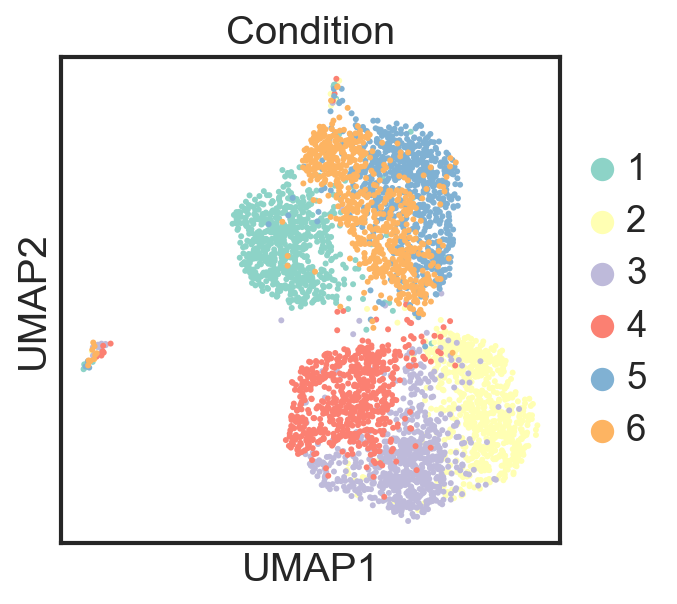

In [15]:
adata.obs['Condition'] = adata.obs['condition']
adata.uns['Condition_colors'] = adata.uns['condition_colors']
adata.obs['Condition'] = [sub.replace('con', '') for sub in adata.obs['Condition']]
adata.obs['Condition'] = adata.obs['Condition'].astype('category')
adata.obs['Condition'] = adata.obs['Condition'].cat.reorder_categories(['1','2','3','4','5','6'])


sc.pl.umap(adata, color = 'Condition')

In [16]:
meta = pd.read_csv( pathToData + '../processed_files/20240425_mESCs_metadata.csv', index_col=0)
meta.head(2)

condition        celltype  leiden plate  n_counts  n_genes  \
e1_1.m-ESC_con1       con1  Shh Signalling       2    e1    7306.0     3604   
e1_10.m-ESC_con1      con1  Shh Signalling       2    e1    9948.0     4020   

                  percent_mito   S_score  G2M_score phase  X_umap-0  X_umap-1  
e1_1.m-ESC_con1       0.068478  0.024311   0.121200   G2M  4.863987  8.068169  
e1_10.m-ESC_con1      0.032744  0.075215   0.022867     S  8.427104  6.595975

In [17]:
adata.obs['celltype'] = meta['celltype']
adata.obs.head(2)

n_counts  n_genes  percent_mito   S_score  G2M_score phase  \
e1_1.m-ESC_con1     7306.0     3604      0.068478  0.024311   0.121200   G2M   
e1_10.m-ESC_con1    9948.0     4020      0.032744  0.075215   0.022867     S   

                  batch        name condition plate leiden Condition  \
e1_1.m-ESC_con1   m-ESC  m-ESC_con1      con1    e1      1         1   
e1_10.m-ESC_con1  m-ESC  m-ESC_con1      con1    e1      4         1   

                        celltype  
e1_1.m-ESC_con1   Shh Signalling  
e1_10.m-ESC_con1  Shh Signalling

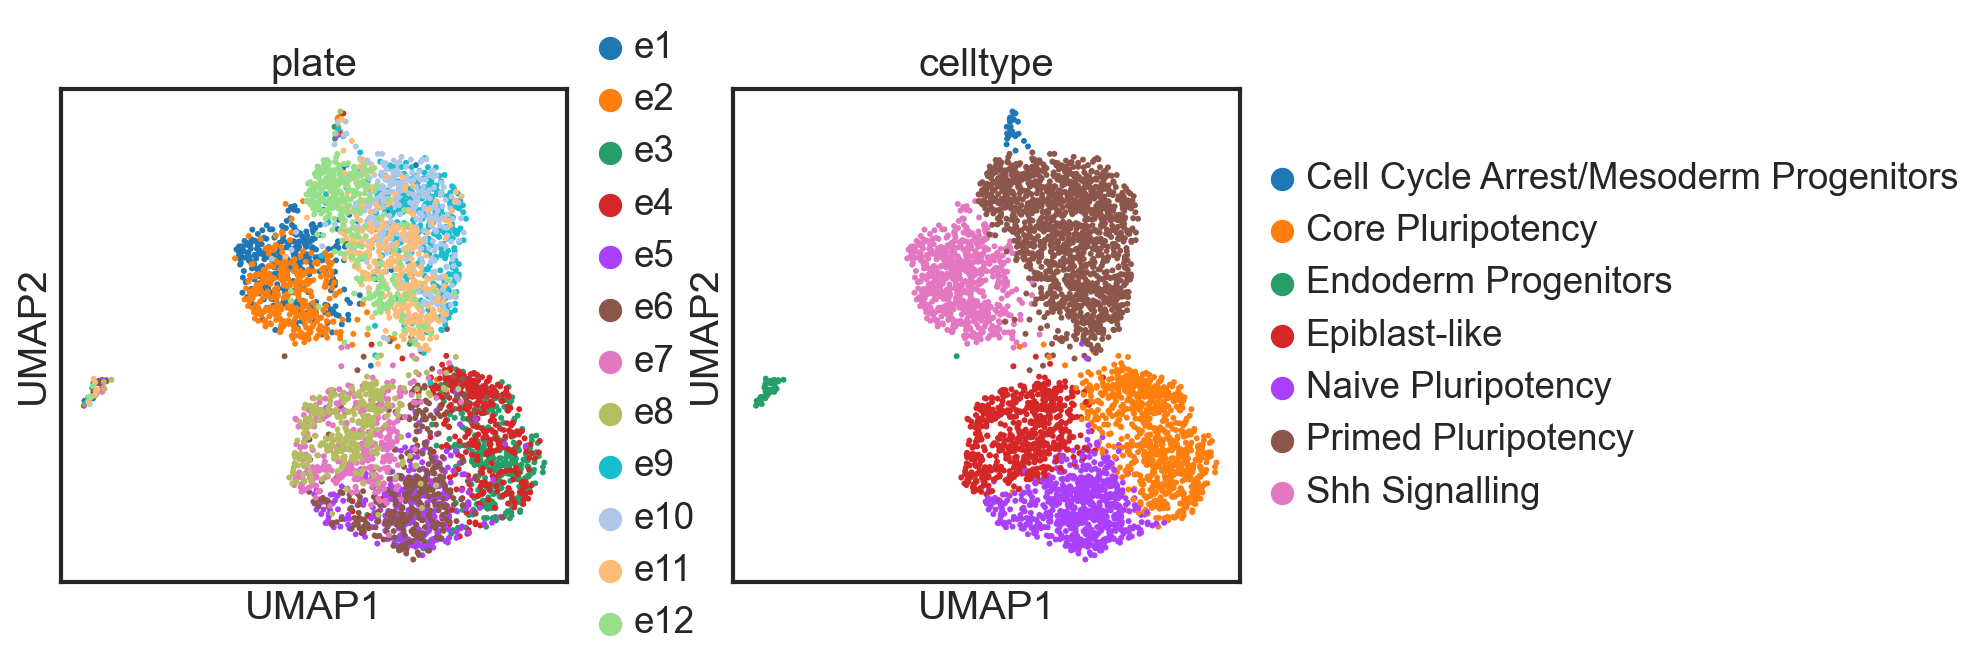

In [18]:
sc.pl.umap(adata, color = ['plate','celltype'])

In [19]:
#adata.obs['diffx'] = adata.obs['Condition']

dict_ct = {'1':'ESLIF',
 '2':'2i',
 '3':'2i',
           '4':'2i',
          '5':'ESLIF',
          '6':'ESLIF'}

adata.obs['diffx'] = (
    adata.obs["Condition"]
    .map(lambda x: dict_ct.get(x, x))
    .astype("category")
)

adata.obs['diffx'] = adata.obs['diffx'].astype(str)

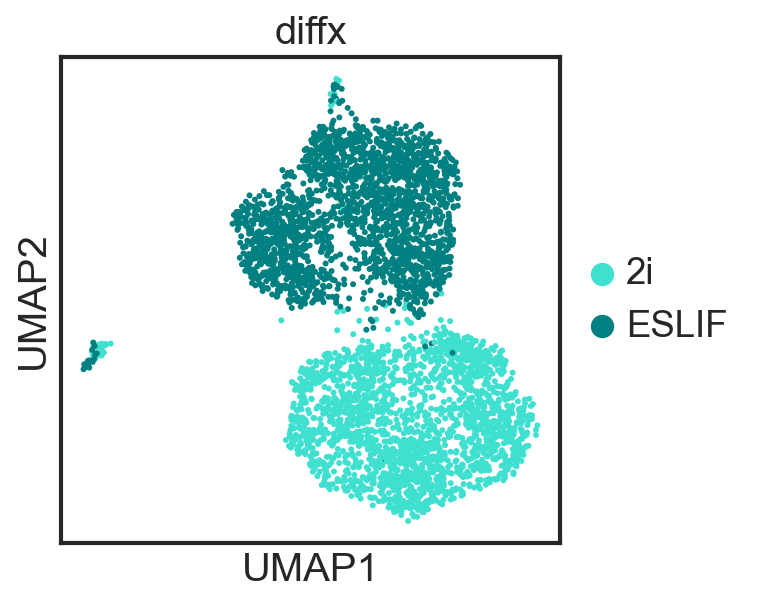

In [20]:
cols = ['turquoise', 'teal']
sc.pl.umap(adata, color = 'diffx', palette = cols )

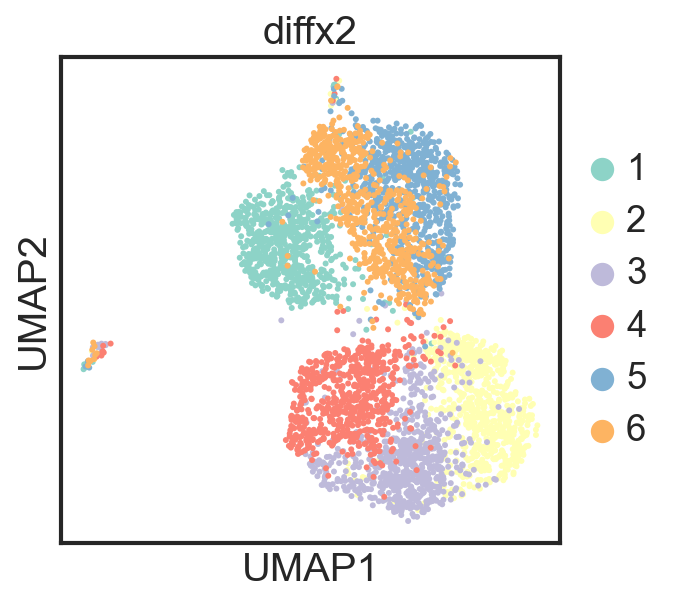

In [21]:
adata.obs['diffx2'] = adata.obs['Condition']
adata.uns['diffx2_colors'] = adata.uns['Condition_colors']
adata.obs['diffx2'] = adata.obs['diffx2'].astype('category')
adata.obs['diffx2'] = adata.obs['diffx2'].cat.reorder_categories(['1','2','3','4','5','6'])
sc.pl.umap(adata, color = 'diffx2')

In [22]:
adata = adata[adata.obs['diffx'] == '2i']

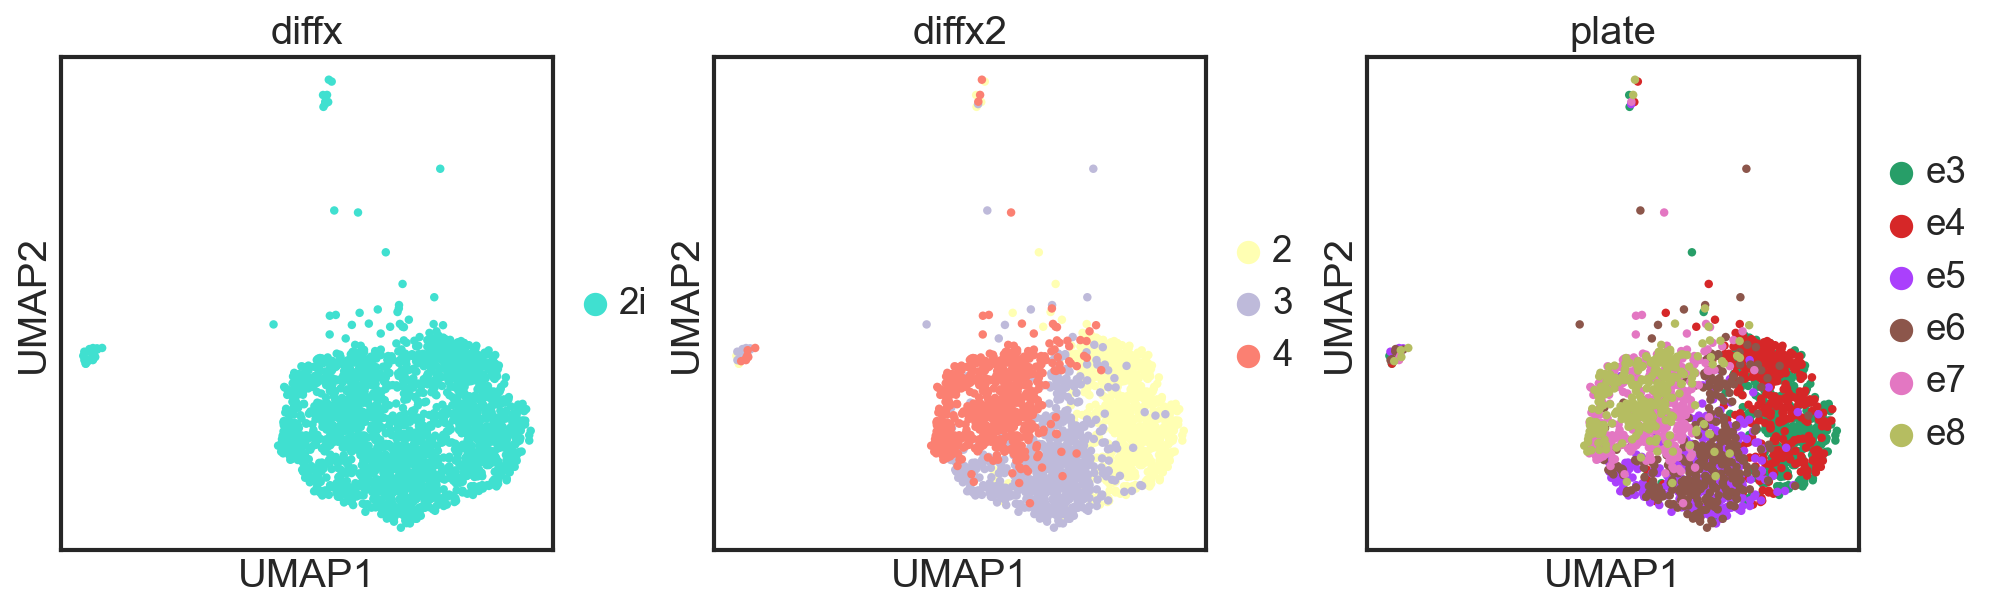

In [23]:
sc.pl.umap(adata, color = ['diffx','diffx2','plate'])

In [24]:
adata.obs.head(2)

n_counts  n_genes  percent_mito   S_score  G2M_score phase  \
e3_1.m-ESC_con2    17232.0     5635      0.066789  0.034575   0.058125   G2M   
e3_10.m-ESC_con2   19973.0     6193      0.053804  0.049880   0.029702     S   

                  batch        name condition plate leiden Condition  \
e3_1.m-ESC_con2   m-ESC  m-ESC_con2      con2    e3      5         2   
e3_10.m-ESC_con2  m-ESC  m-ESC_con2      con2    e3      5         2   

                           celltype diffx diffx2  
e3_1.m-ESC_con2   Core Pluripotency    2i      2  
e3_10.m-ESC_con2  Core Pluripotency    2i      2

In [25]:
sc.settings.verbosity = 2

## start decoupler
make pseudobulks, filter, run pydeseq

In [26]:
import decoupler as dc

In [27]:
# define groups and samples
groups = 'diffx2'
samples = 'plate'
ref = '2'

### define pseudobulks 

In [28]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    groups_col= groups,
    sample_col= samples,
    mode='mean',
    min_cells=10,
    min_counts=0
)


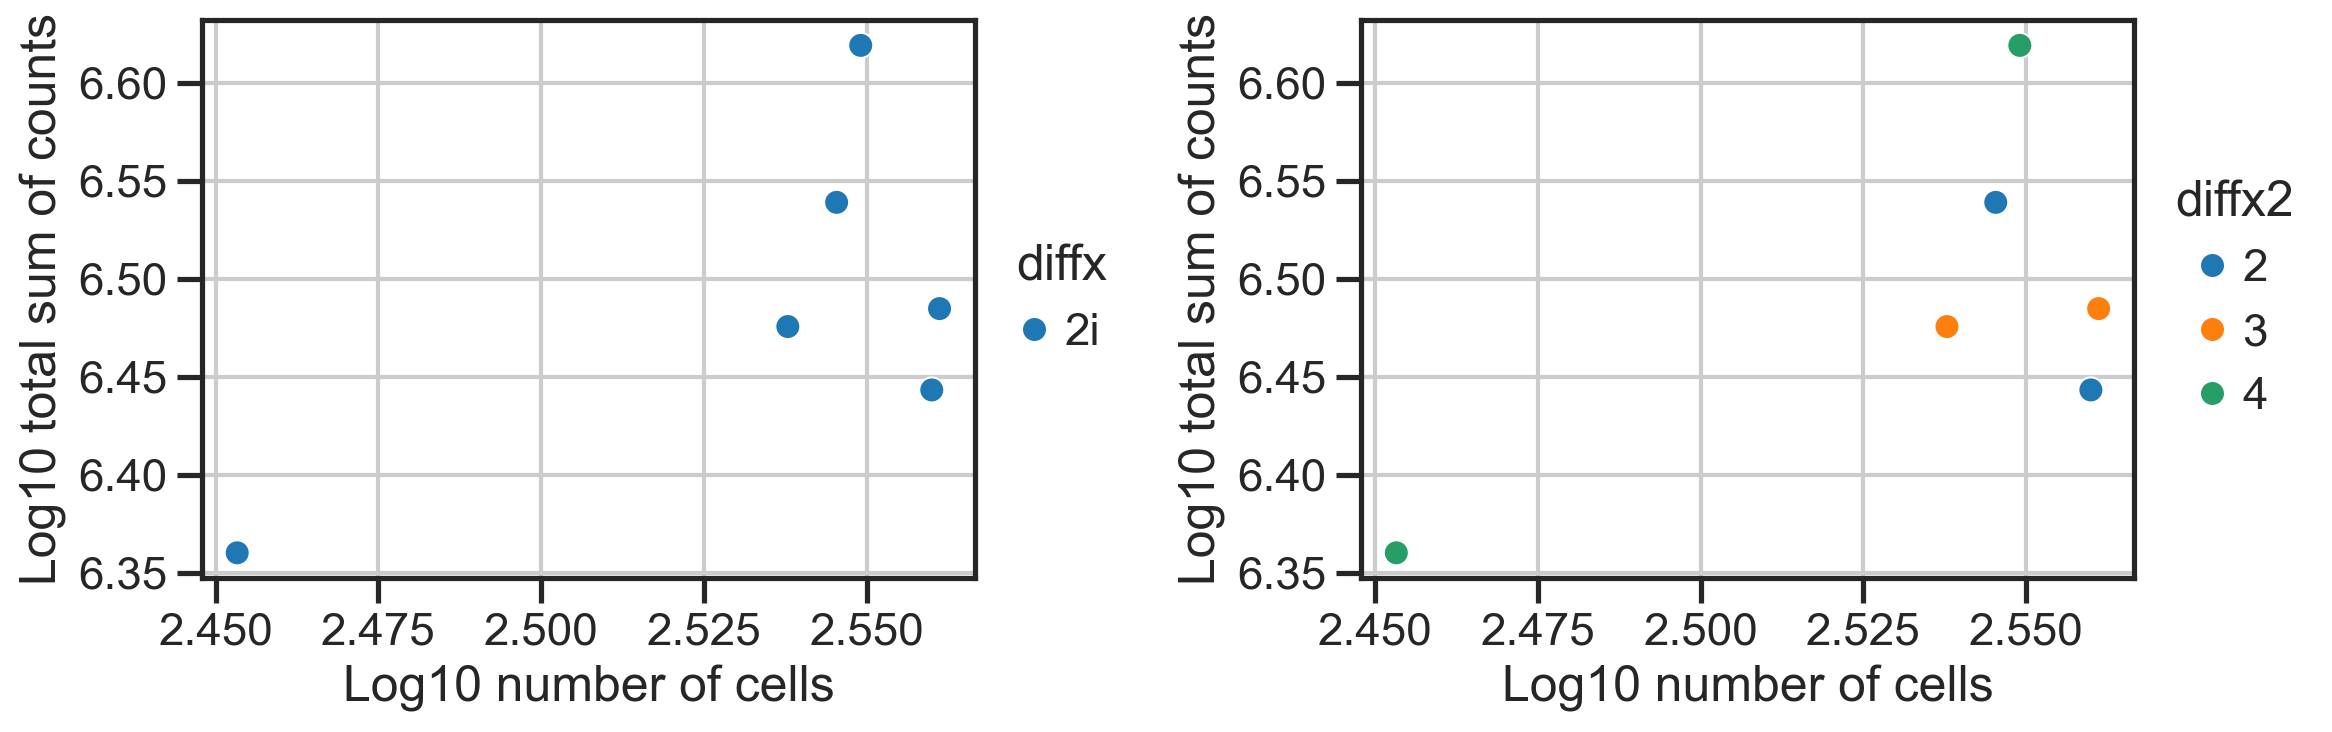

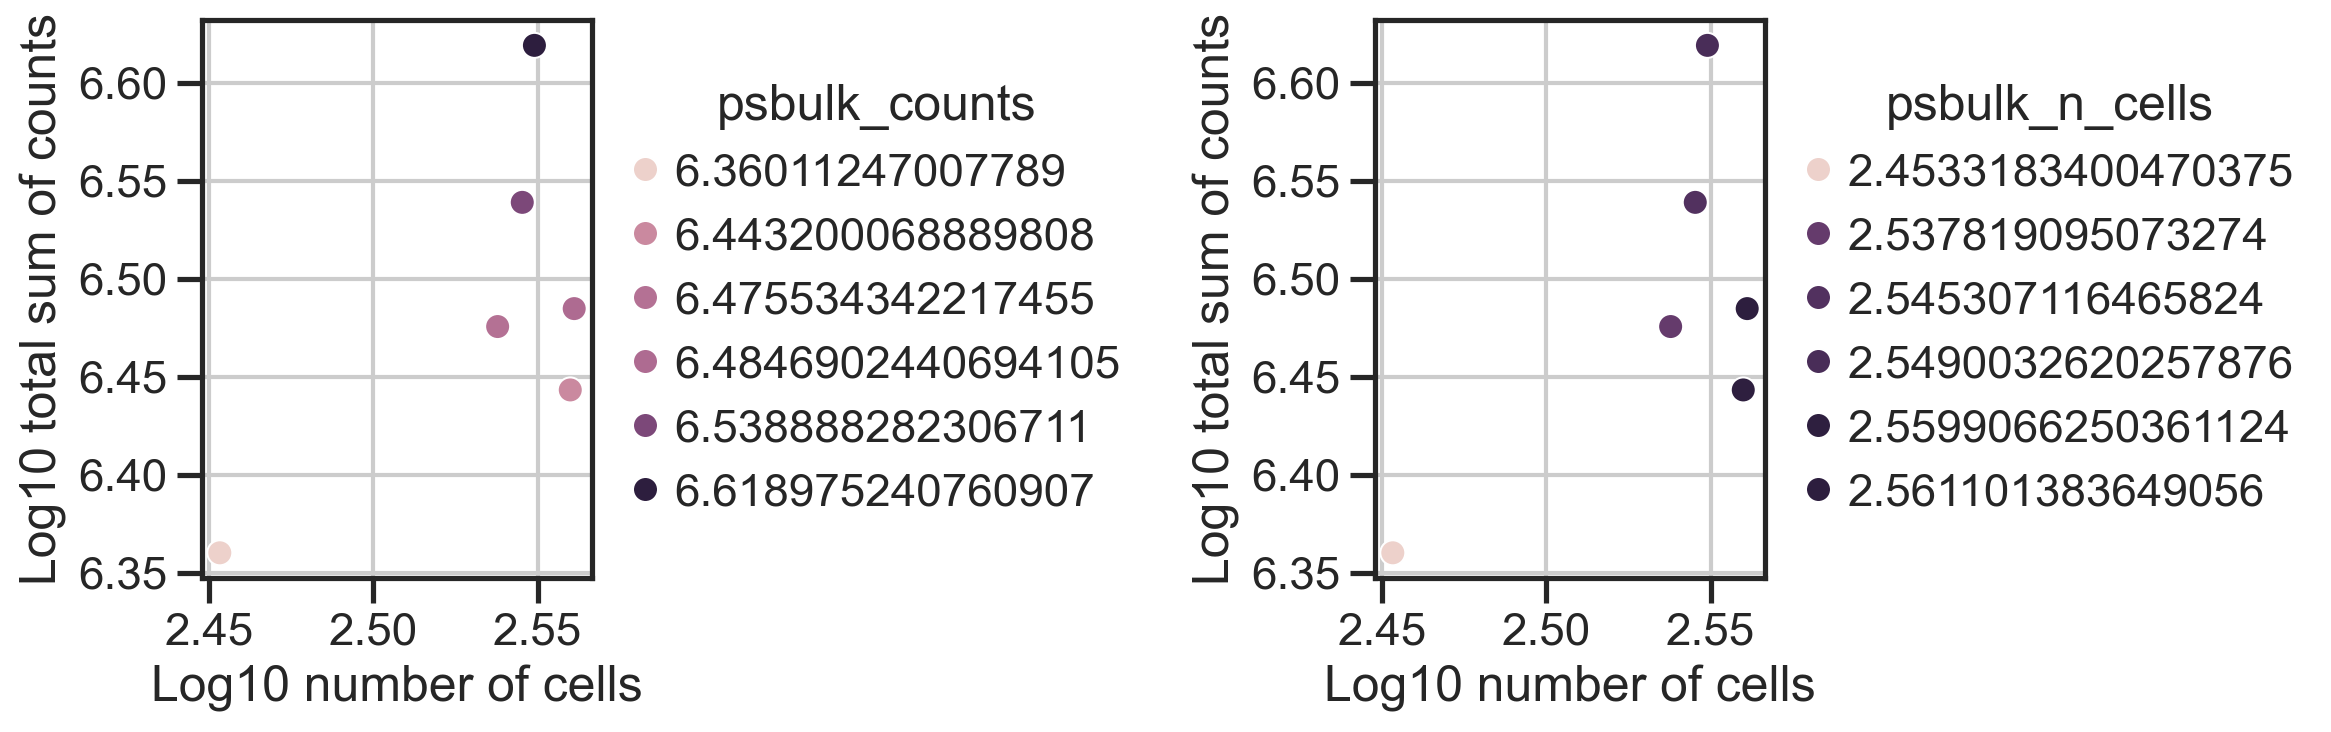

In [29]:
dc.plot_psbulk_samples(pdata, groupby=['diffx','diffx2'],figsize=(12, 4))

dc.plot_psbulk_samples(pdata, groupby=['psbulk_counts','psbulk_n_cells'], figsize=(12, 4))



<Axes: ylabel='Count'>

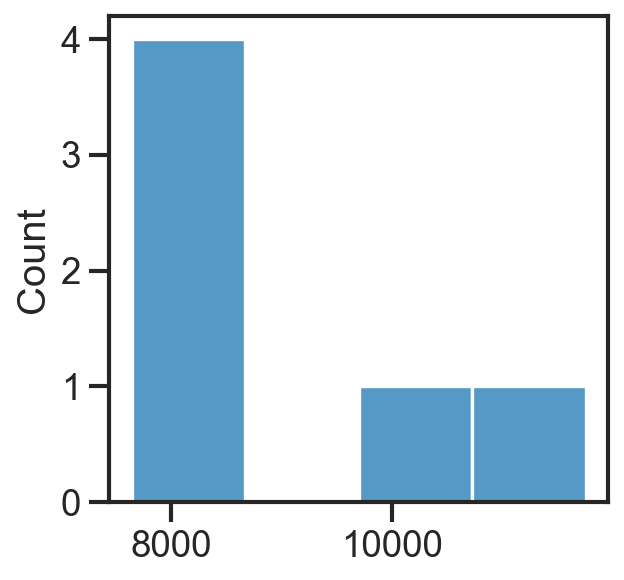

In [30]:
sns.histplot(pdata.obs['psbulk_counts']/pdata.obs['psbulk_n_cells'])

### filter pseudobulks

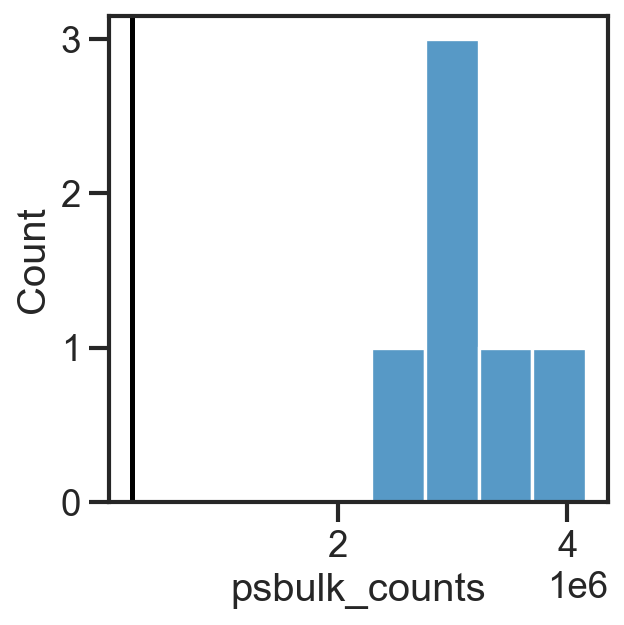

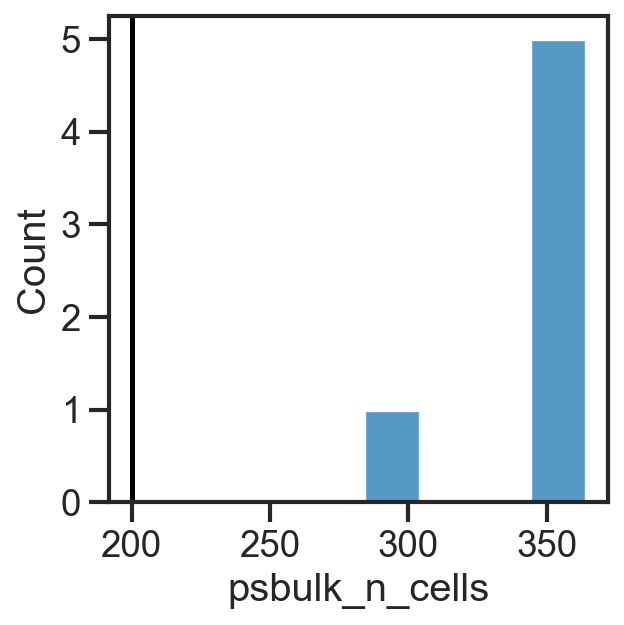

In [31]:
sns.histplot(pdata.obs['psbulk_counts'], bins = 4)
plt.axvline(200000, color = 'black')
plt.show()
sns.histplot(pdata.obs['psbulk_n_cells'], bins = 4)
plt.axvline(200, color = 'black')

In [32]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    adata,
    groups_col= groups,
    sample_col= samples,
    mode='sum',
    min_cells=200,
    min_counts=200000
)

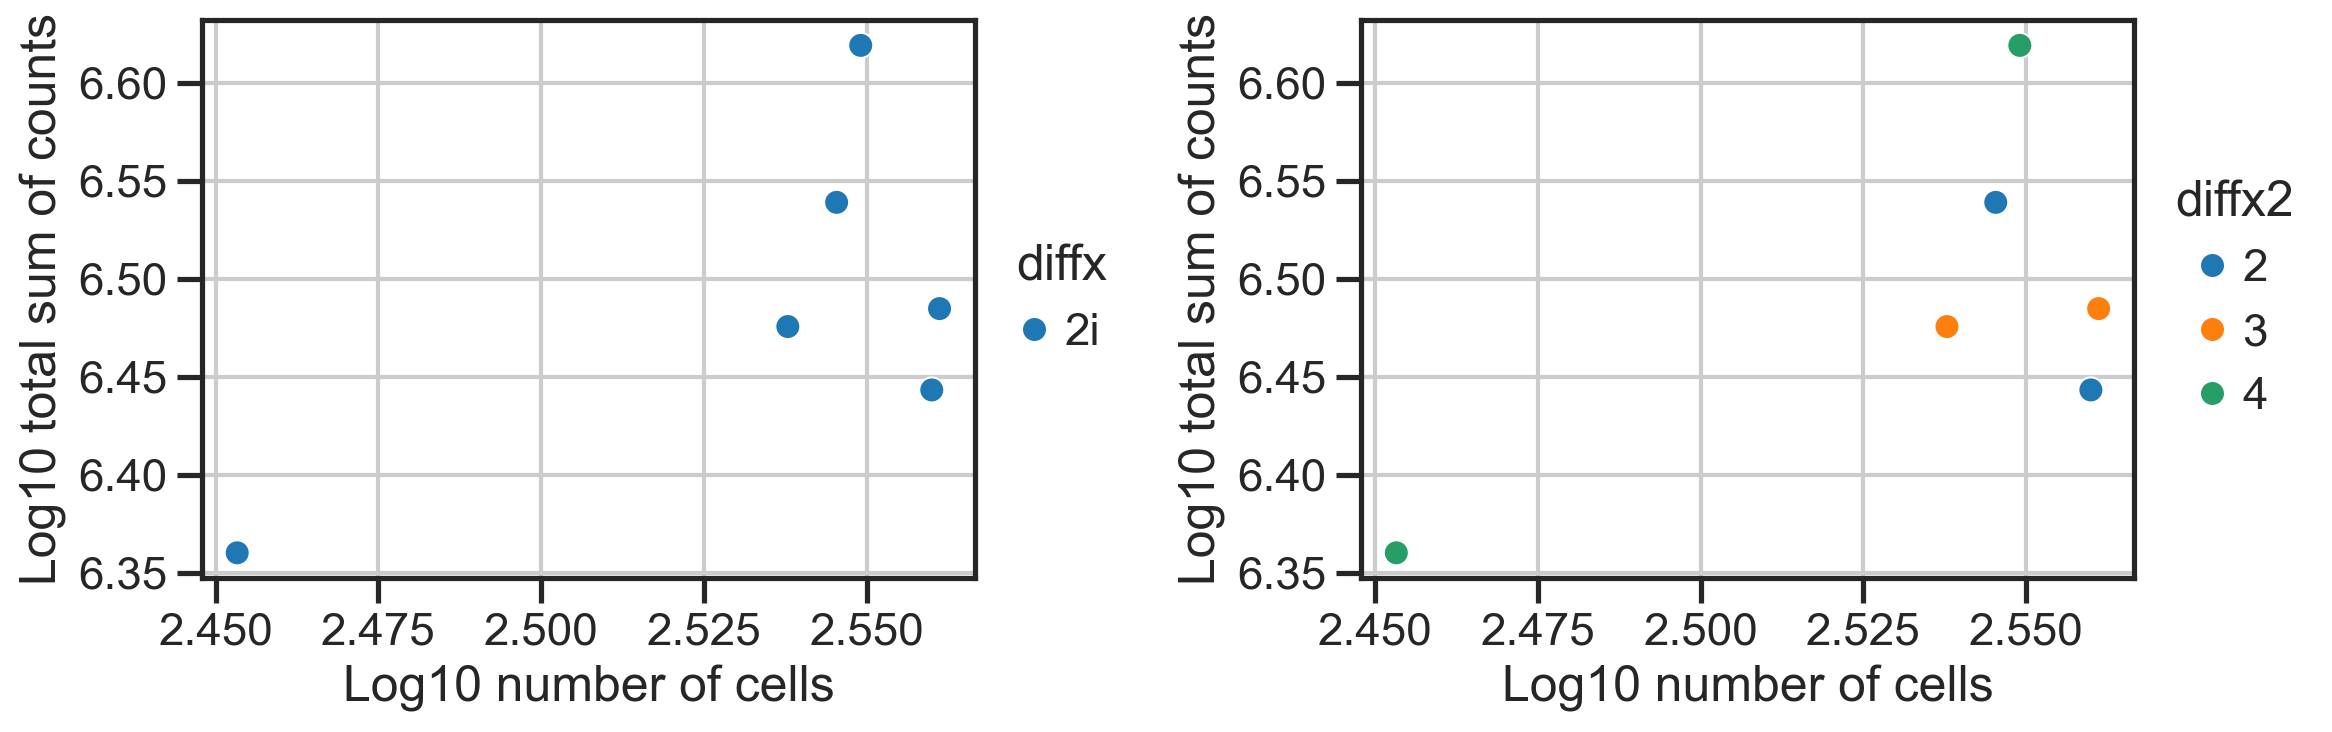

In [33]:
dc.plot_psbulk_samples(pdata, groupby=['diffx','diffx2'],figsize=(12, 4))


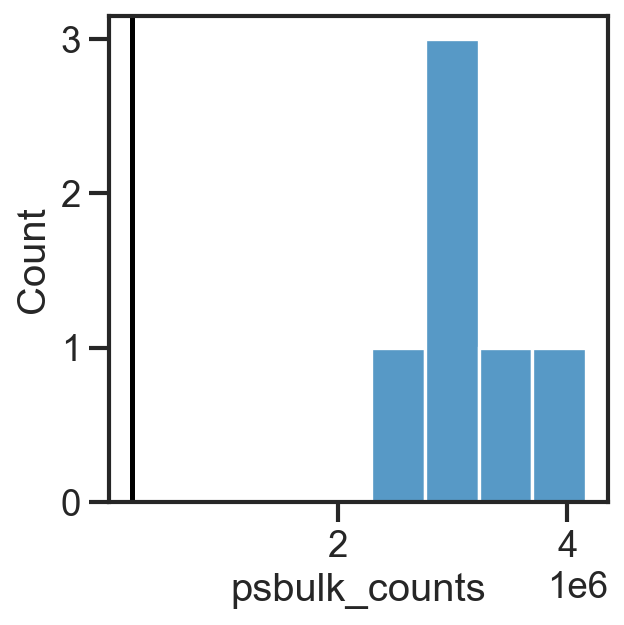

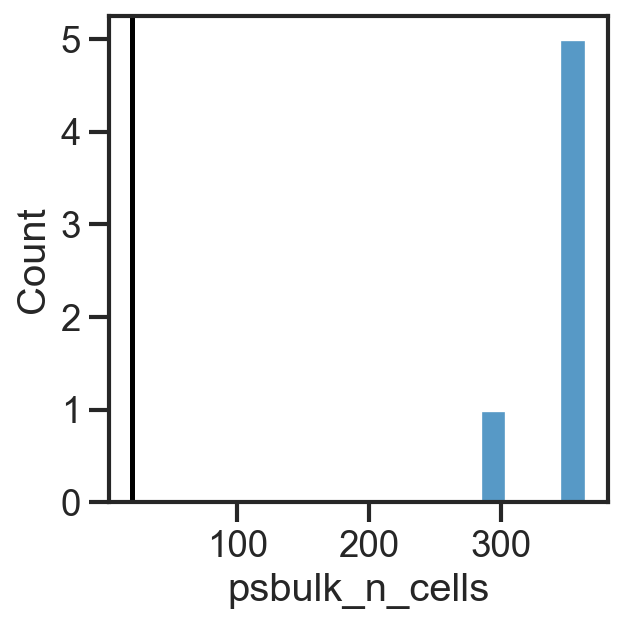

In [34]:
sns.histplot(pdata.obs['psbulk_counts'], bins = 4)
plt.axvline(200000, color = 'black')
plt.show()
sns.histplot(pdata.obs['psbulk_n_cells'], bins = 4)
plt.axvline(20, color = 'black')

### normalise and log-transform counts

In [35]:
# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)


normalizing counts per cell
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=5
    finished (0:00:00)


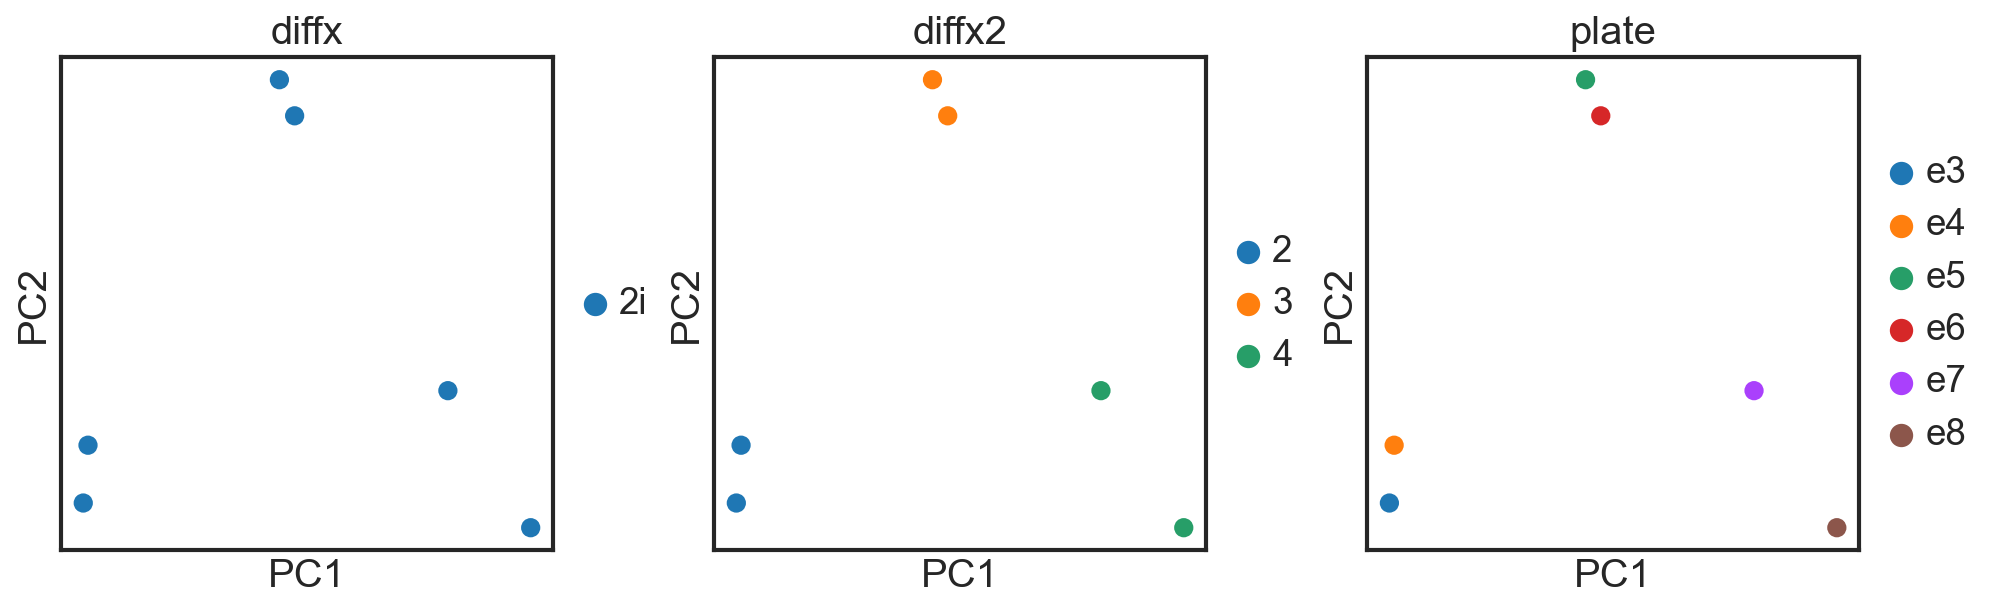

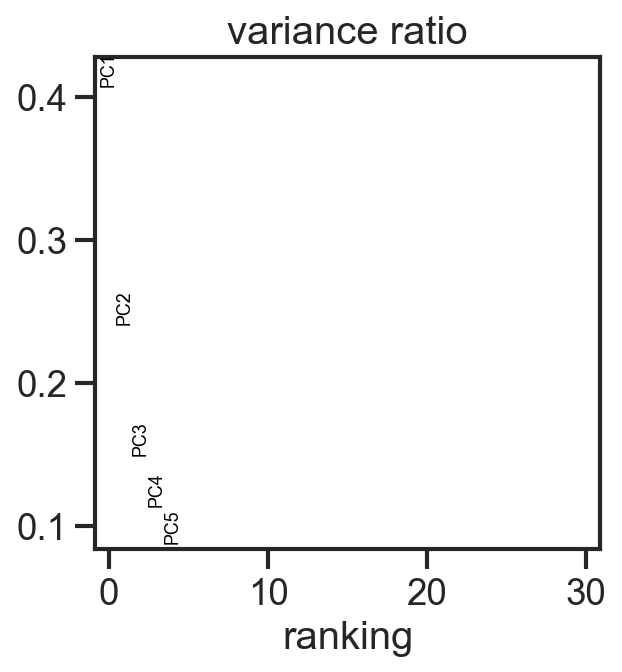

In [36]:
pdata.obs['diffx2'] = pdata.obs['diffx2'].astype('category')
pdata.obs['plate'] = pdata.obs['plate'].astype('category')
sc.pl.pca(pdata, color=['diffx','diffx2', 'plate'], ncols=3, size=300)
sc.pl.pca_variance_ratio(pdata)



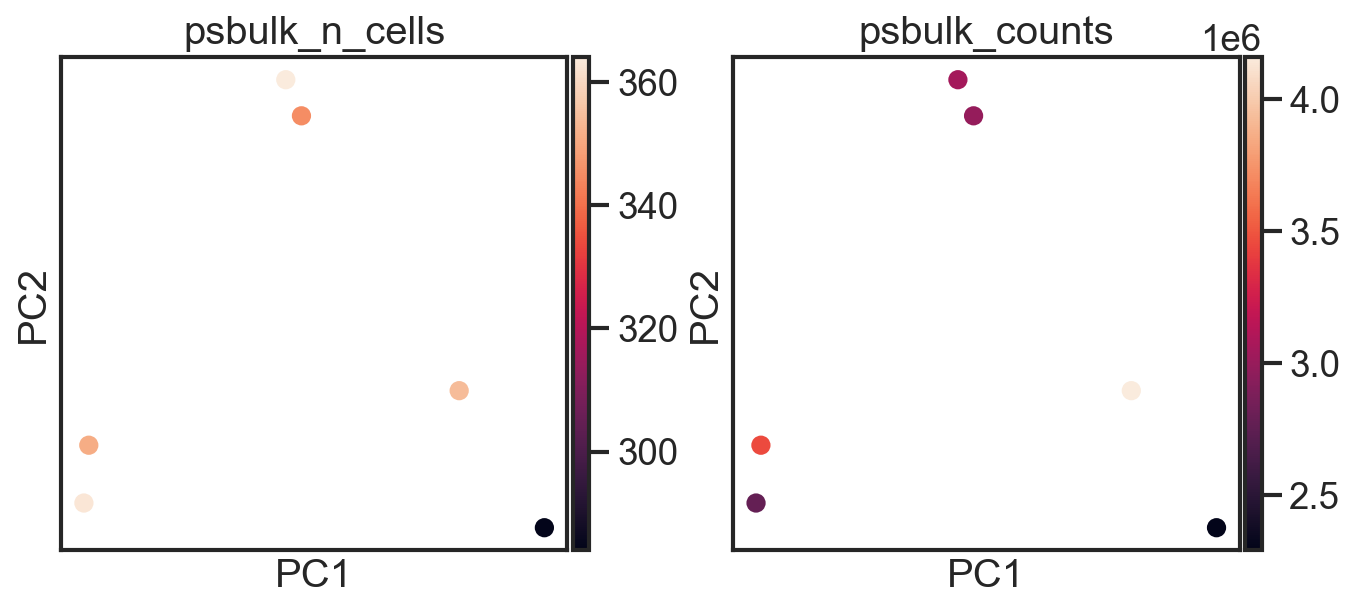

In [37]:
sc.pl.pca(pdata, color=['psbulk_n_cells', 'psbulk_counts'], ncols=3, size=300)


### perform feature (gene) filtering

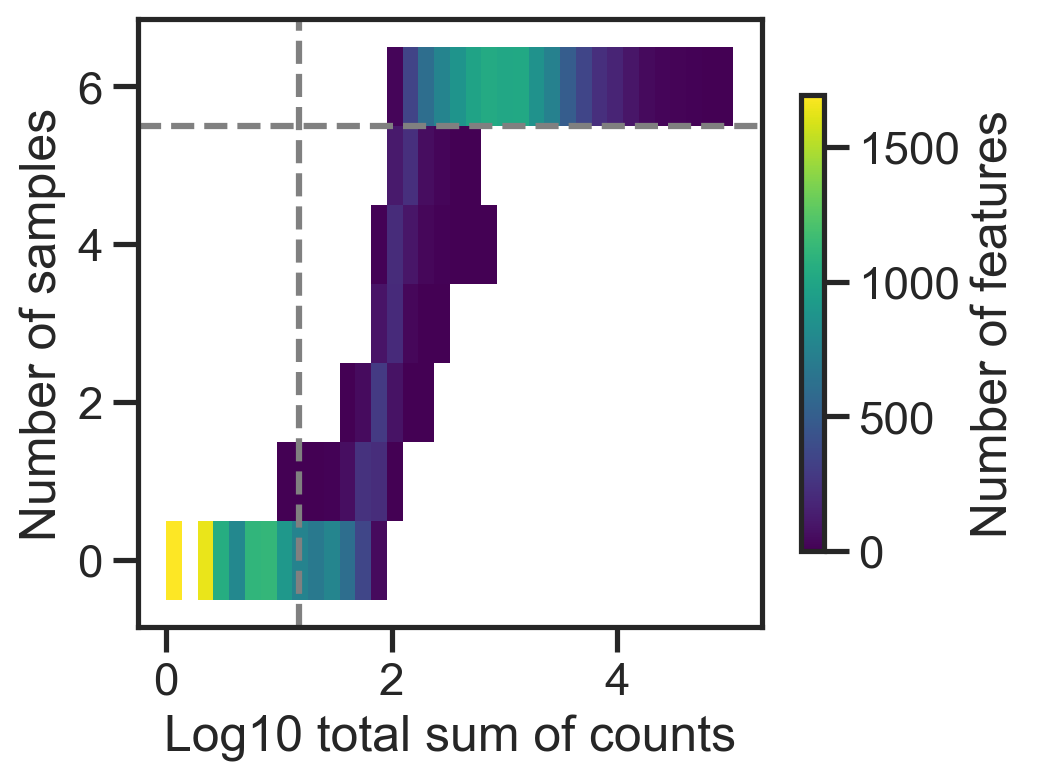

In [38]:
dc.plot_filter_by_expr(pdata, group='diffx', min_count=15, min_total_count=15)

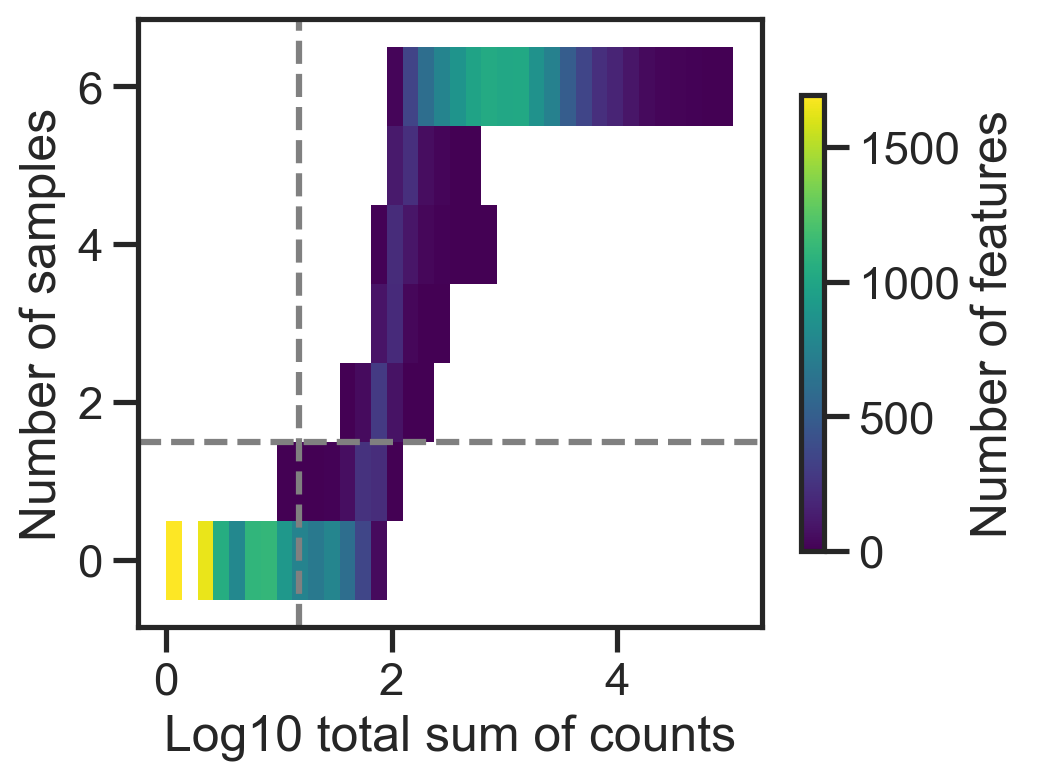

In [39]:
dc.plot_filter_by_expr(pdata, group='diffx2', min_count=15, min_total_count=15)

In [40]:
pdata

AnnData object with n_obs × n_vars = 6 × 23231
    obs: 'batch', 'name', 'condition', 'plate', 'Condition', 'diffx', 'diffx2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'log1p', 'pca', 'diffx_colors', 'diffx2_colors', 'plate_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

In [41]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(pdata, group=groups, min_count=15, min_total_count=15)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 6 × 11182
    obs: 'batch', 'name', 'condition', 'plate', 'Condition', 'diffx', 'diffx2', 'psbulk_n_cells', 'psbulk_counts'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'log1p', 'pca', 'diffx_colors', 'diffx2_colors', 'plate_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props', 'counts'

### start DEseq differential analysis

In [42]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=1)
dds = DeseqDataSet(
    adata=pdata,
    design_factors=groups,
    ref_level=[groups, ref],
    refit_cooks=True,
    inference=inference,
)

In [43]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 285.12 seconds.

Fitting dispersion trend curve...
... done in 1.06 seconds.

Fitting MAP dispersions...
... done in 271.25 seconds.

Fitting LFCs...
... done in 12.74 seconds.

Refitting 0 outliers.



In [44]:
# Extract contrast between LINS vs ESC
stat_res_1 = DeseqStats(
    dds,
    contrast=[groups, ref,'3' ],
    inference=inference,
)

# Extract contrast between LINS vs ESC
stat_res_2 = DeseqStats(
    dds,
    contrast=[groups, ref,'4' ],
    inference=inference,
)

# Extract contrast between LINS vs ESC
stat_res_3 = DeseqStats(
    dds,
    contrast=[groups, '3','4' ],
    inference=inference,
)

In [45]:
# Compute Wald test
stat_res_1.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: diffx2 2 vs 3
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik  140.839874        0.334509  0.197278  1.695620  0.089958   
0610010F05Rik   53.463184       -0.620749  0.251965 -2.463626  0.013754   
0610012G03Rik  161.345261        0.056762  0.238615  0.237879  0.811975   
0610030E20Rik   60.193974       -0.475741  0.223807 -2.125675  0.033530   
0610037L13Rik   98.004738       -0.216153  0.218823 -0.987798  0.323252   
...                   ...             ...       ...       ...       ...   
Zxdc            87.533470        0.311990  0.165184  1.888741  0.058926   
Zyg11b         188.318420       -0.339539  0.116179 -2.922543  0.003472   
Zyx             37.632492       -0.907348  0.363838 -2.493823  0.012638   
Zzef1           78.886536       -0.637812  0.253917 -2.511890  0.012009   
Zzz3           388.336517       -0.156389  0.144955 -1.078882  0.280640   

                   padj  
0610009B22Rik  0.2704

... done in 3.26 seconds.



In [46]:
# Compute Wald test
stat_res_2.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: diffx2 2 vs 4
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik  140.839874        0.128893  0.193919  0.664676  0.506257   
0610010F05Rik   53.463184       -1.052199  0.239928 -4.385473  0.000012   
0610012G03Rik  161.345261       -0.073267  0.237230 -0.308844  0.757440   
0610030E20Rik   60.193974       -0.099750  0.231211 -0.431426  0.666159   
0610037L13Rik   98.004738       -0.472703  0.214067 -2.208197  0.027231   
...                   ...             ...       ...       ...       ...   
Zxdc            87.533470        0.128091  0.157711  0.812188  0.416684   
Zyg11b         188.318420       -0.101573  0.118409 -0.857816  0.390994   
Zyx             37.632492       -0.417978  0.374128 -1.117206  0.263906   
Zzef1           78.886536       -0.402408  0.257078 -1.565317  0.117509   
Zzz3           388.336517        0.063314  0.146217  0.433010  0.665008   

                   padj  
0610009B22Rik  0.6799

... done in 3.04 seconds.



In [47]:
# Compute Wald test
stat_res_3.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: diffx2 3 vs 4
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik  140.839874       -0.205615  0.198632 -1.035158  0.300595   
0610010F05Rik   53.463184       -0.431450  0.217639 -1.982413  0.047433   
0610012G03Rik  161.345261       -0.130029  0.237938 -0.546483  0.584734   
0610030E20Rik   60.193974        0.375991  0.219277  1.714687  0.086403   
0610037L13Rik   98.004738       -0.256550  0.210300 -1.219921  0.222495   
...                   ...             ...       ...       ...       ...   
Zxdc            87.533470       -0.183899  0.166452 -1.104818  0.269239   
Zyg11b         188.318420        0.237965  0.113291  2.100484  0.035686   
Zyx             37.632492        0.489370  0.349529  1.400085  0.161488   
Zzef1           78.886536        0.235404  0.245229  0.959936  0.337088   
Zzz3           388.336517        0.219703  0.145345  1.511594  0.130637   

                   padj  
0610009B22Rik  0.5725

... done in 3.82 seconds.



In [48]:
# Extract results
results_df_1 = stat_res_1.results_df
results_df_1.head(2)

# Extract results
results_df_2 = stat_res_2.results_df
results_df_2.head(2)

# Extract results
results_df_3 = stat_res_3.results_df

In [49]:
results_df_1['p_log'] = -np.log10(results_df_1['padj'])
results_df_2['p_log'] = -np.log10(results_df_2['padj'])
results_df_3['p_log'] = -np.log10(results_df_3['padj'])

In [59]:
import matplotlib.patheffects as pe

def plotVolcano(df,top = 25, title='', genes = None):
    sns.set_context('talk')
    sns.set_style('white')
    sns.set_style('ticks')
    top = 20
    sign_thr=0.05
    lFCs_thr=0.5
    color_pos='#D62728'
    color_neg='#1F77B4'
    color_null='gray'
    if genes == None:
        genes = list(df.sort_values(by='padj')[0:top].index) #+ ['Jarid2','Phc1','Utf1']
    else:
        genes = list(set(genes) & set(df.index))
    
    fig, ax = plt.subplots(figsize = (8,8))
    sns.scatterplot(data = df,
                       x='log2FoldChange',linewidth = 0,ax=ax,
                    y='p_log', size = 1, color = color_null)
    
    sns.scatterplot(data = df[(df['padj'] < 0.05) & (df['log2FoldChange'] < -0.5) ],
                       x='log2FoldChange',linewidth = 0,ax=ax,
                    y='p_log', size = 1, color = color_neg)
    
    sns.scatterplot(data = df[(df['padj'] < 0.05) & (df['log2FoldChange'] > 0.5) ],
                       x='log2FoldChange',linewidth = 0,ax=ax,
                    y='p_log', size = 1, color = color_pos)
    
    ax.axhline(lFCs_thr, color = 'black', linestyle = 'dashed')
    ax.axvline(lFCs_thr, color = 'black', linestyle = 'dashed')
    ax.axvline(-lFCs_thr, color = 'black', linestyle = 'dashed')
    
    
    for gene in list(set(df.index) & set(genes)):
        plt.text(df.loc[gene]['log2FoldChange'],df.loc[gene]['p_log'],gene, size = 20,
                path_effects=[pe.withStroke(linewidth=2, foreground="white")]) 
    ax.legend([],frameon = False)
    ax.set_xlabel('')#Log Fold Change')
    ax.set_ylabel('')#Adjusted p-value [-log10]')
    ax.set_xlim([-8.1,8.1])
#    ax.set_ylim([-2.1,240])
    plt.title(title)
    #plt.savefig('20240430_volcano_nolabel.png',dpi=300)

In [60]:
geneset = ['Foxa2', 'Sox17', 'Sox7', 'Gata4', 'Gata6', 
         'Mesp2', 'Notch1', 'Ccng1', 'p53',
         'Sox2', 'Esrrb', 'Nanog',
         'Epha4', 'Tex19.1',
         'Gjb3', 'Hes1', 'Klf4',
         'Igfbp2', 'Tuba1a', 'Fos',
         'Nr0b1', 'Tet2', 'Dppa2', 'Dppa4', 'Bmp4',
         'Gbx2', 'Ptch1', 'Sox11', 'Lefty1', 'Shh',
         'Utf1', 'Jarid2', 'Phc1',
         'Eed', 'Phc1', 'Phc2', 'Ring1', 'Suv39h2', 'Setd1a', 'Setd3', 'Setdb2', 'Setd7', 'Dnmt3a', 'Dnmt3b', 'Dnmt3l', 'Tet1']

geneset = ['Tbx1', 'Tcf15', 'Sox17', 'Noto', 'Pax6', 'Otx2', 'T']

geneset = ['Dll1', 'Tbx6', 'Hes7', 'Notch1', 'Aldh1a2', 'Ripply2',  'Pax3', 
           'Meox1', 'Uncx', 'Grb10', 'Kdr', 'Sox7', 'Car2', 'Gata6', 'Gata4', 'Mixl1', 
           'Gsc', 'Hand1', 'Lfng', 'Eya1', 'Mesp1', 'Bmp4', 'Tbx20',
           'Tbx4', 'Stx3', 'Klf9', 'Nanog', 'Dppa5a', 'Dazl', 'Prdm14',
           'Cdh1', 'Epcam', 'Foxa2', 'Lefty1', 'Foxa1', 'Sox17',
           'Nkx1-2', 'Sox1', 'Sox2', 'Sox21', 'Elavl3', 'Crabp1', 'Onecut2', 'T', 
           'Cdx2', 'Fgf8', 'Wnt3a', 'Otx2' ]

In [61]:
sc.set_figure_params(dpi = 80, dpi_save = 300)

In [62]:
def length(df):
    print('downregulated: ')
    print(len(df[(df['padj'] < 0.05) & (df['log2FoldChange'] < -0.5) ]))
    print('upregulated: ')
    print(len(df[(df['padj'] < 0.05) & (df['log2FoldChange'] > 0.5) ]))



In [63]:
length(results_df_1)
print('\n')
length(results_df_2)

downregulated: 
499
upregulated: 
605


downregulated: 
1092
upregulated: 
1054


In [64]:
list(results_df_1.sort_values(by='padj')[0:30].index)

['Calcoco2',
 'Ldha',
 'Iqgap1',
 'Socs3',
 'Tex19.1',
 'Srsf6',
 'Gabarapl2',
 'Marc2',
 'Bnip3',
 'AA467197',
 'Oat',
 'Arl14epl',
 'Rbpms2',
 'Myof',
 'Ak4',
 'Arih2',
 'Usp48',
 'Trib3',
 'Map1b',
 'Nodal',
 'Ak1',
 'Pfkl',
 'Gpt2',
 'Pgm1',
 'Pttg1',
 'Atf4',
 'Ccng1',
 'Pias2',
 'Mavs',
 'Zmym1']

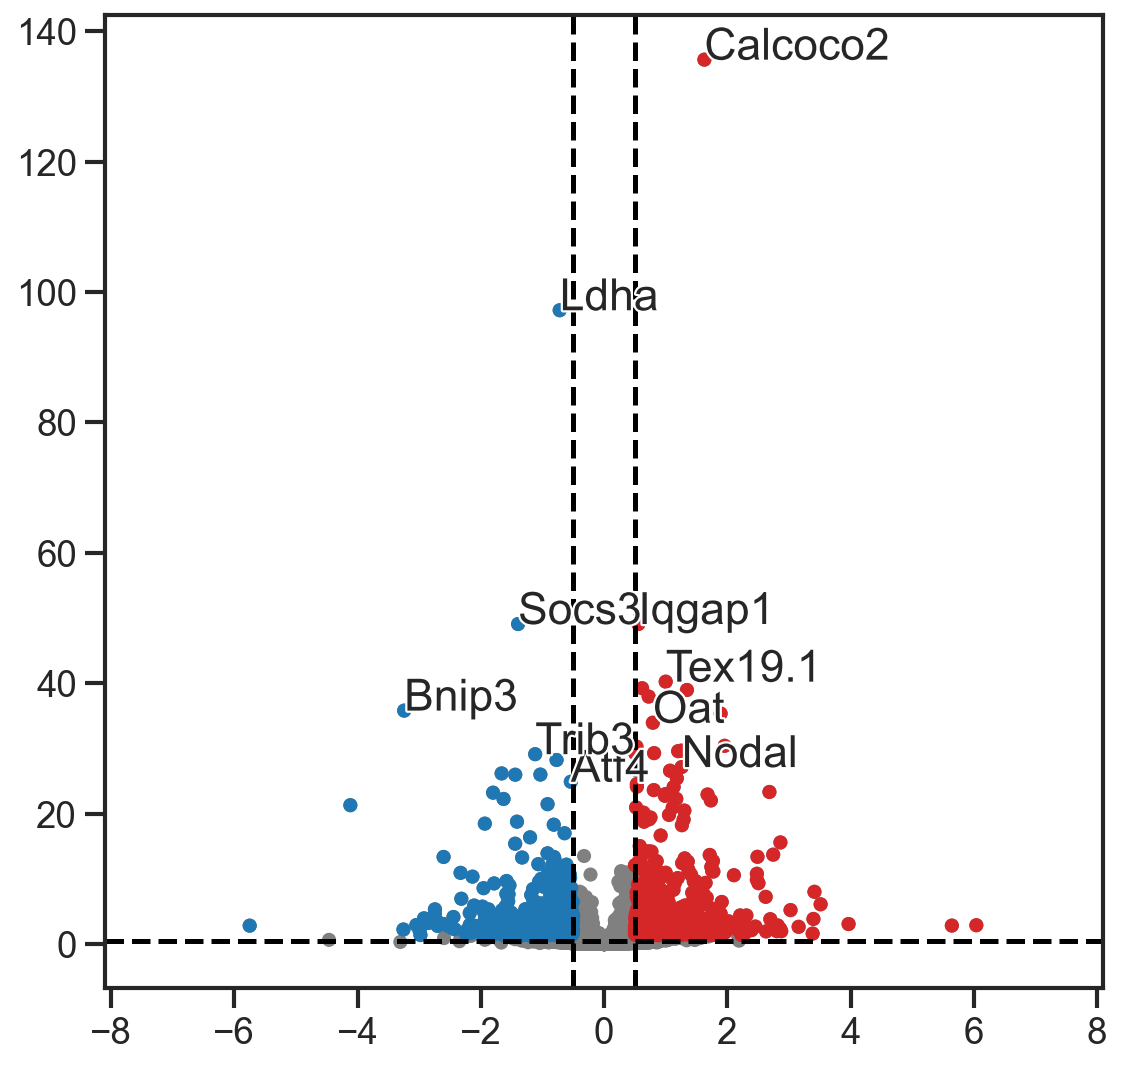

In [69]:
genes_c3 = ['Calcoco2',
 'Ldha',
 'Iqgap1',
 'Socs3',
 'Tex19.1',
# 'Srsf6',
 #'Gabarapl2',
# 'Marc2',
 'Bnip3',
# 'AA467197',
 'Oat',
# 'Arl14epl',
# 'Rbpms2',
 #'Myof',
# 'Ak4',
# 'Arih2',
# 'Usp48',
 'Trib3',
# 'Map1b',
 'Nodal',
# 'Ak1',
# 'Pfkl',
 #'Gpt2',
 #'Pgm1',
 #'Pttg1']
            'Atf4',
           ]
           

plotVolcano(results_df_1, title='', top = 10, genes = genes_c3)
plt.savefig('figures/volcano_c2_vs_c3.png', dpi = 300, bbox_inches = 'tight')

In [66]:
list(results_df_2.sort_values(by='padj')[0:30].index)

['Ldha',
 'Calcoco2',
 'Iqgap1',
 'Lefty2',
 'Marc2',
 'Jam2',
 'Arih2',
 'Bnip3',
 'Bcat1',
 'Pgm1',
 'Gabarapl2',
 'Pfkl',
 'Fn1',
 'Tubb3',
 'Egln1',
 'Smarca5',
 '2210409E12Rik',
 'Usp48',
 'Epb41l4b',
 'Rbpms2',
 'Ifitm3',
 'Marcks',
 'Egln3',
 'Tex19.1',
 'Ak4',
 'AA467197',
 'Myof',
 'Tdrp',
 'Map1b',
 'Crtap']

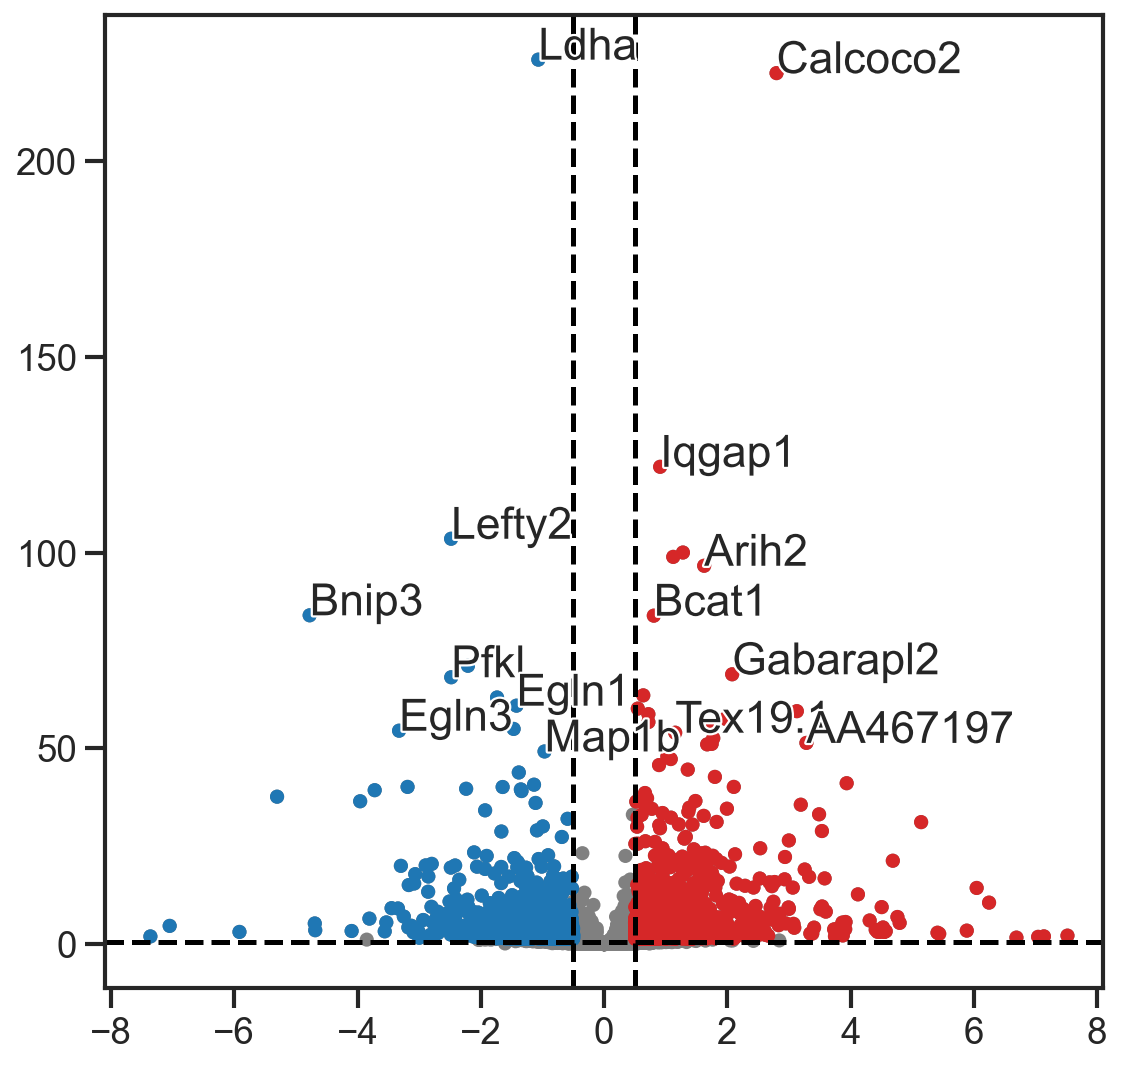

In [72]:
genes_c4 = ['Ldha',
 'Calcoco2',
 'Iqgap1',
 'Lefty2',
 #'Marc2',
 #'Jam2',
 'Arih2',
 'Bnip3',
 'Bcat1',
 #'Pgm1',
 'Gabarapl2',
 'Pfkl',
# 'Fn1',
 #'Tubb3',
 'Egln1',
# 'Smarca5',
# '2210409E12Rik',
# 'Usp48',
 #'Epb41l4b',
# 'Rbpms2',
# 'Ifitm3',
# 'Marcks',
 'Egln3',
 'Tex19.1',
 #'Ak4'
            'AA467197',
# 'Myof',
 #'Tdrp',
 'Map1b',
 #'Crtap'
           ]
plotVolcano(results_df_2, title='', top = 10, genes = genes_c4)
plt.savefig('figures/volcano_c2_vs_c4.png', dpi = 300, bbox_inches = 'tight')

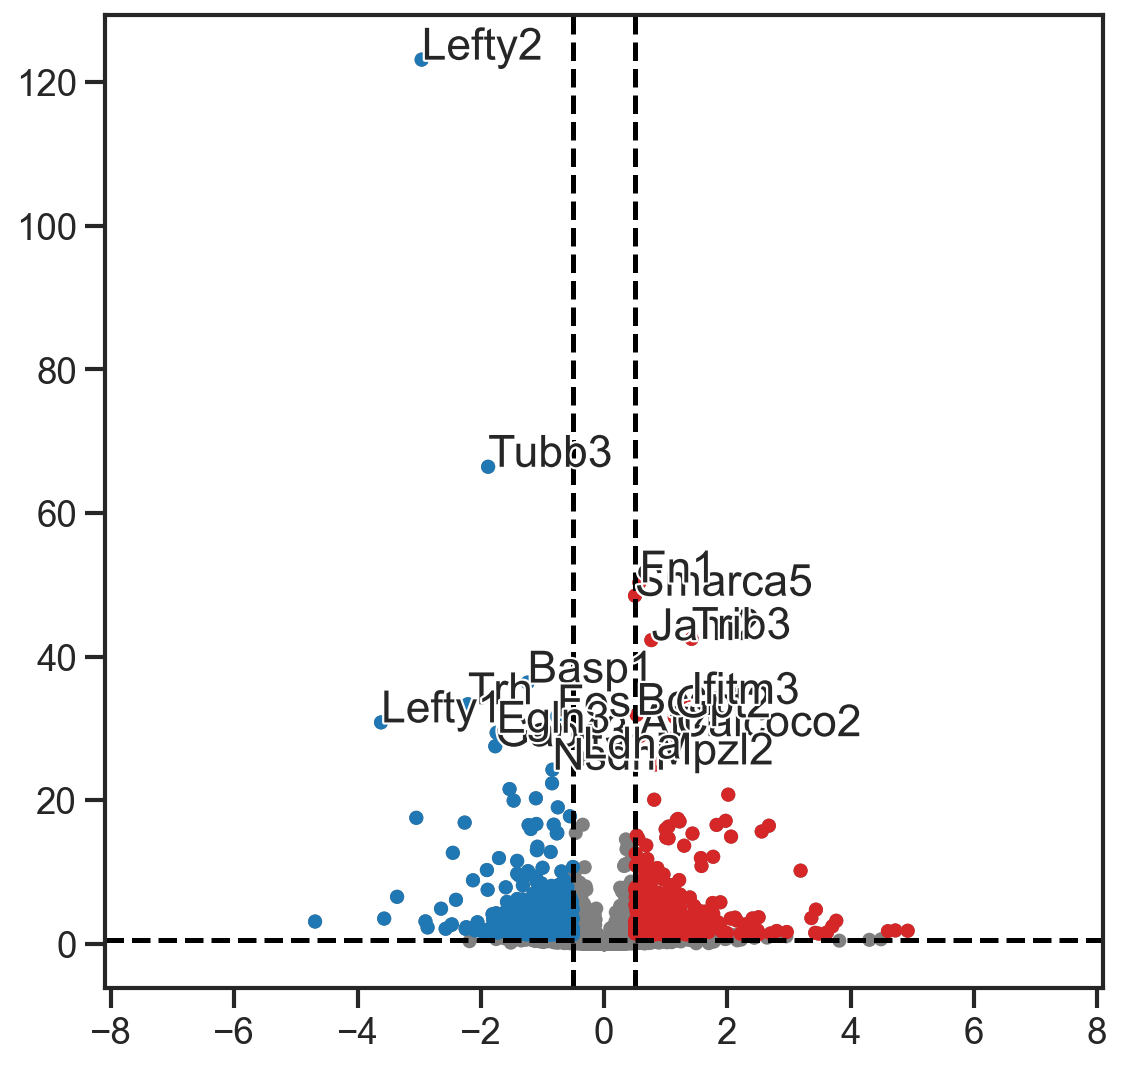

In [68]:
plotVolcano(results_df_3, title='', top = 10)

In [57]:
results_df_1.to_csv('data/20240706_2i_c2vsc3.csv')
results_df_2.to_csv('data/20240706_2i_c2vsc4.csv')
results_df_3.to_csv('data/20240706_2i_c3vsc4.csv')

Text(0.5, 1.0, 'c2 vs c3')

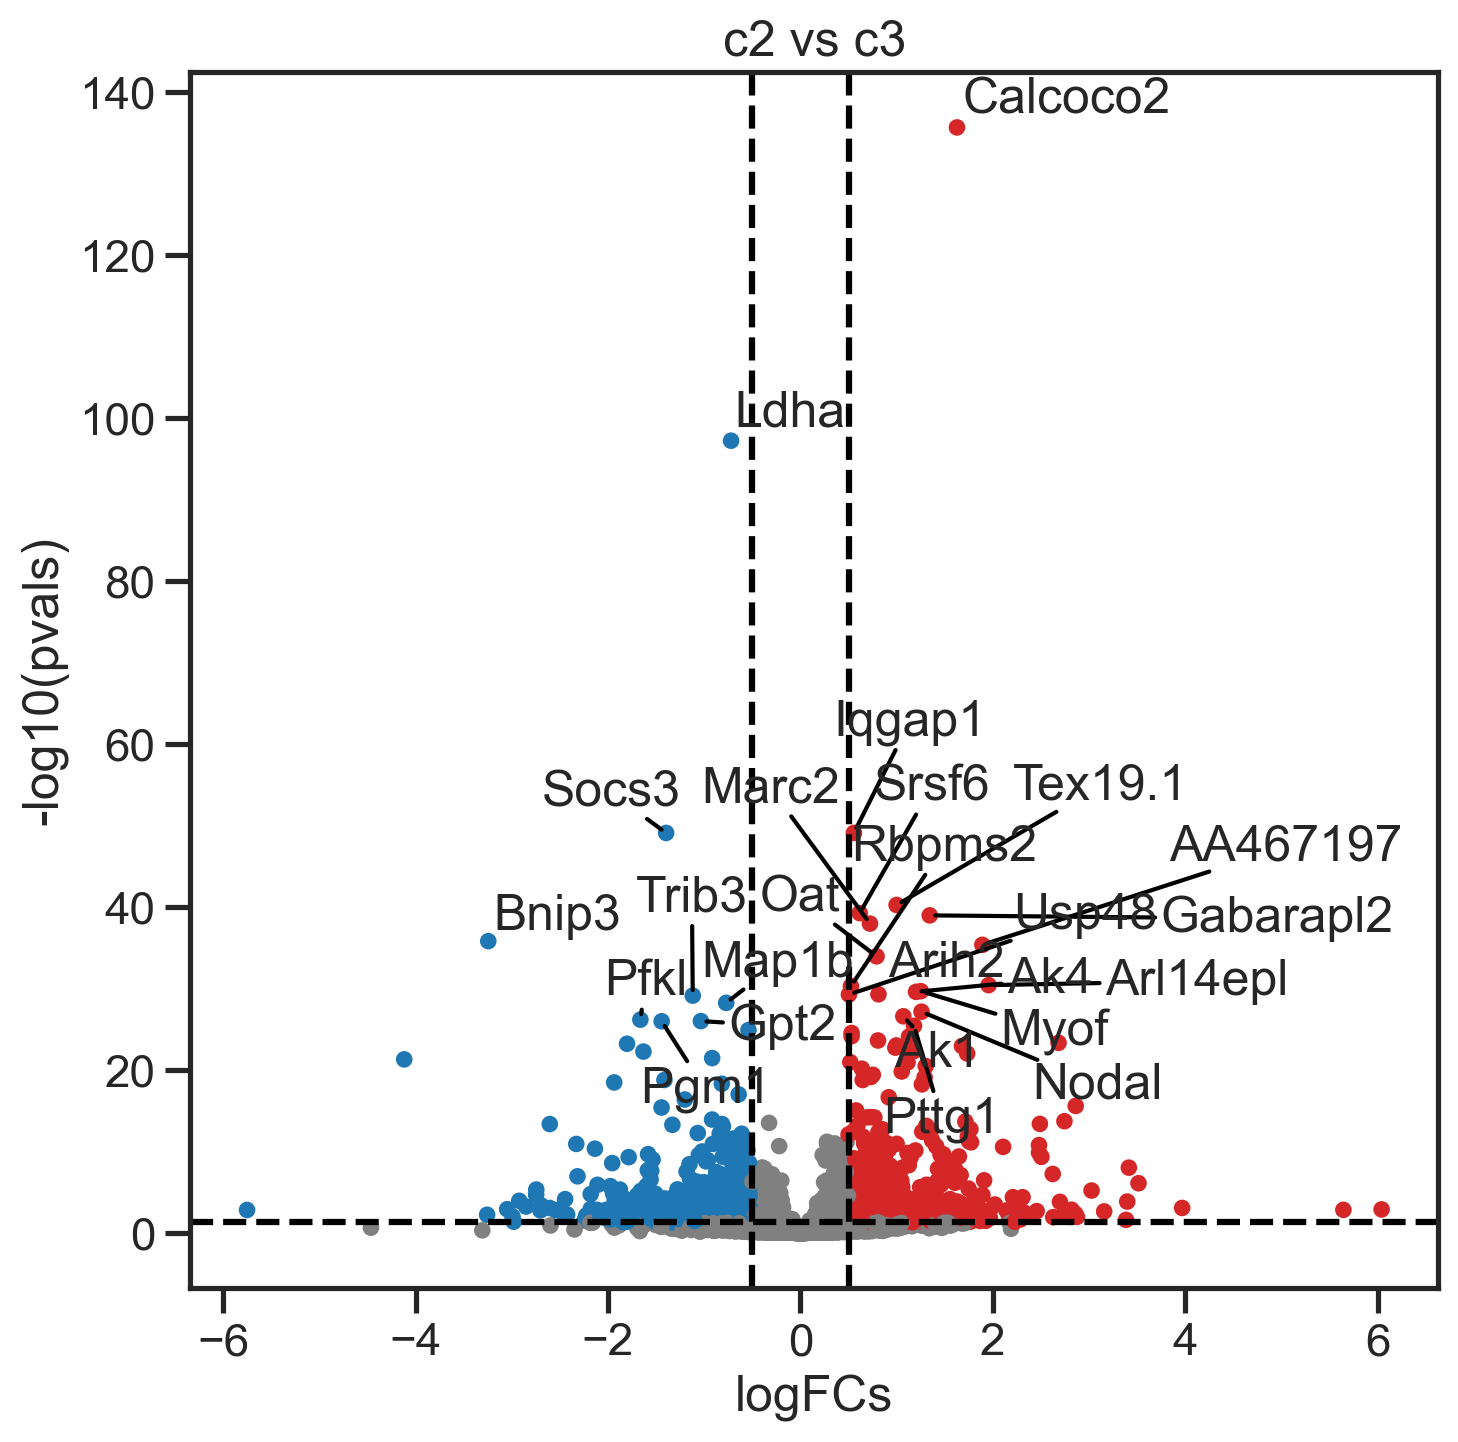

In [58]:
dc.plot_volcano_df(
    results_df_1,
    x='log2FoldChange',
    y='padj',
    top=25,
   # name = 'Jarid2',
    figsize=(8,8),#save='volcano_2ivsESLIF.png'
)
plt.title('c2 vs c3')

Text(0.5, 1.0, 'c2 vs c4')

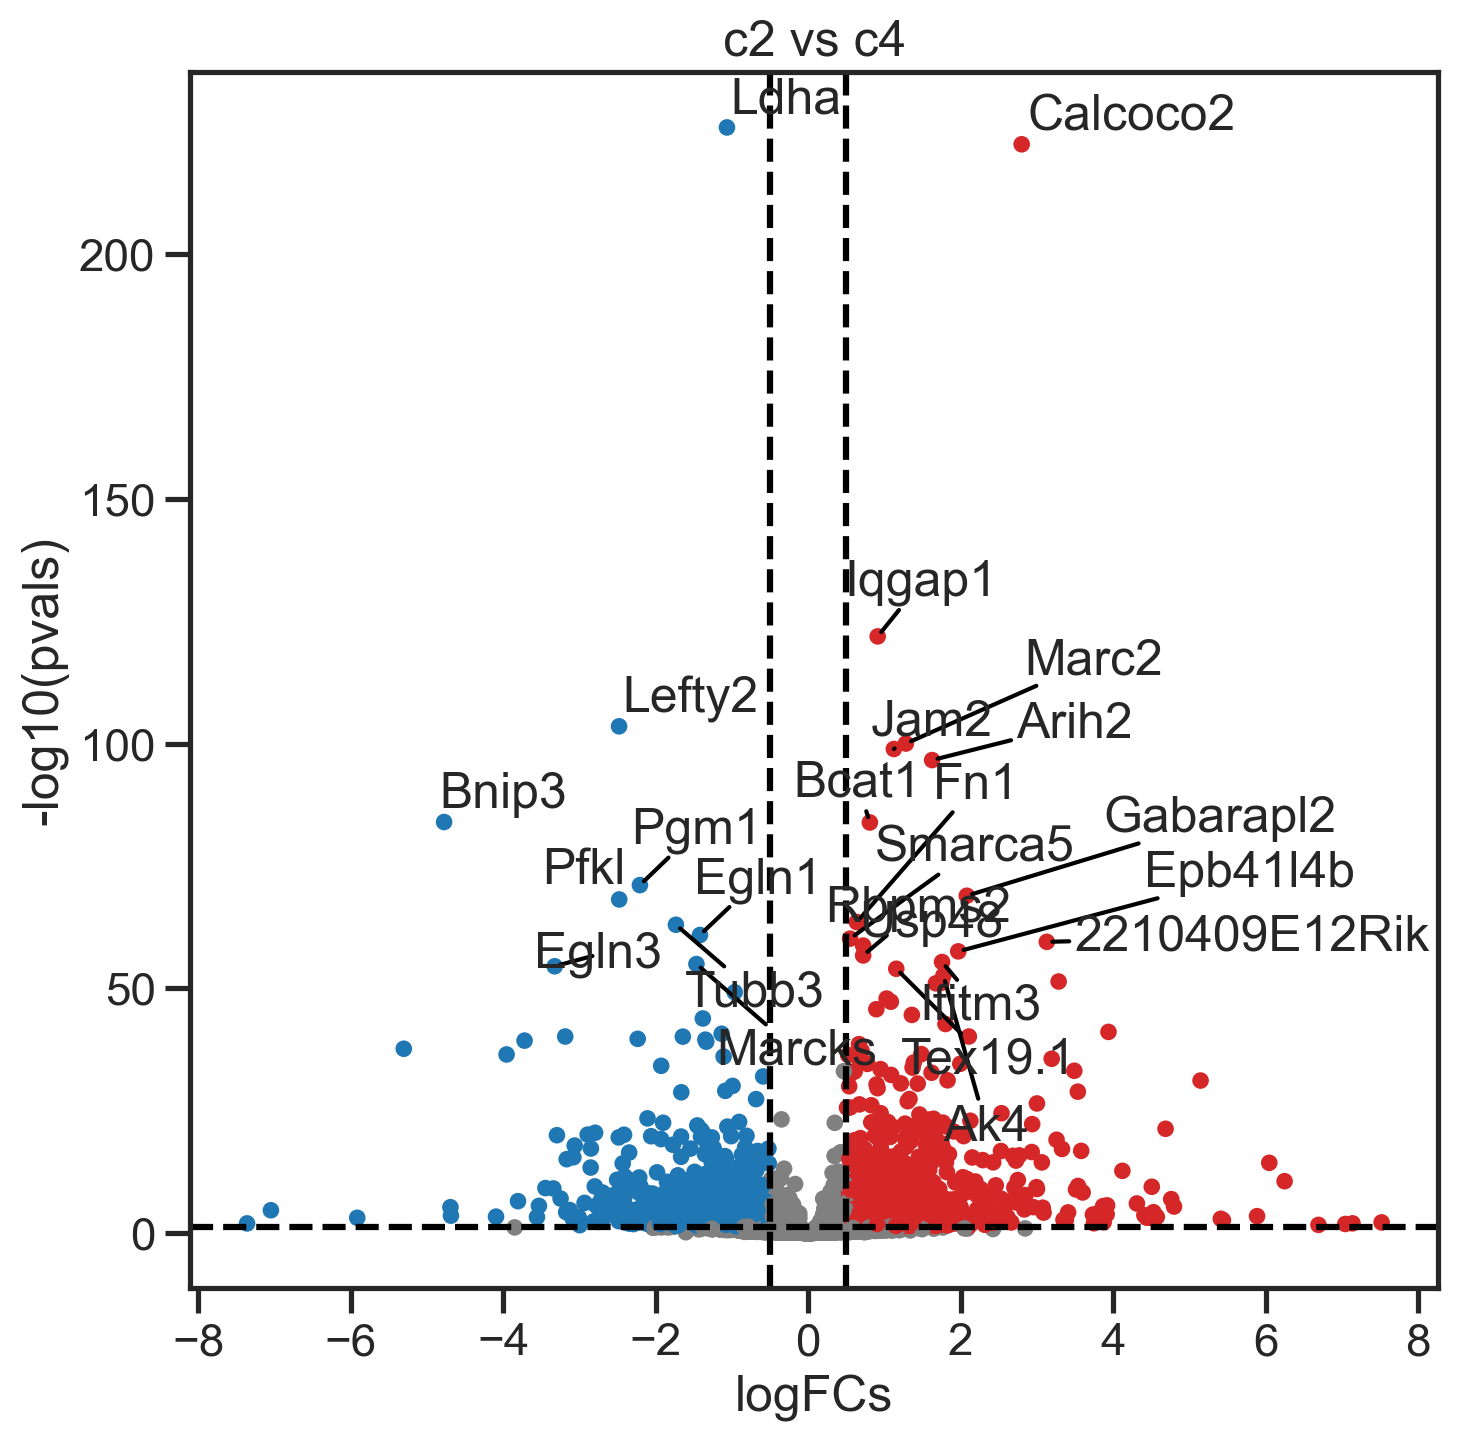

In [59]:
dc.plot_volcano_df(
    results_df_2,
    x='log2FoldChange',
    y='padj',
    top=25,
   # name = 'Jarid2',
    figsize=(8,8),#save='volcano_2ivsESLIF.png'
)
plt.title('c2 vs c4')


Text(0.5, 1.0, 'c3 vs c4')

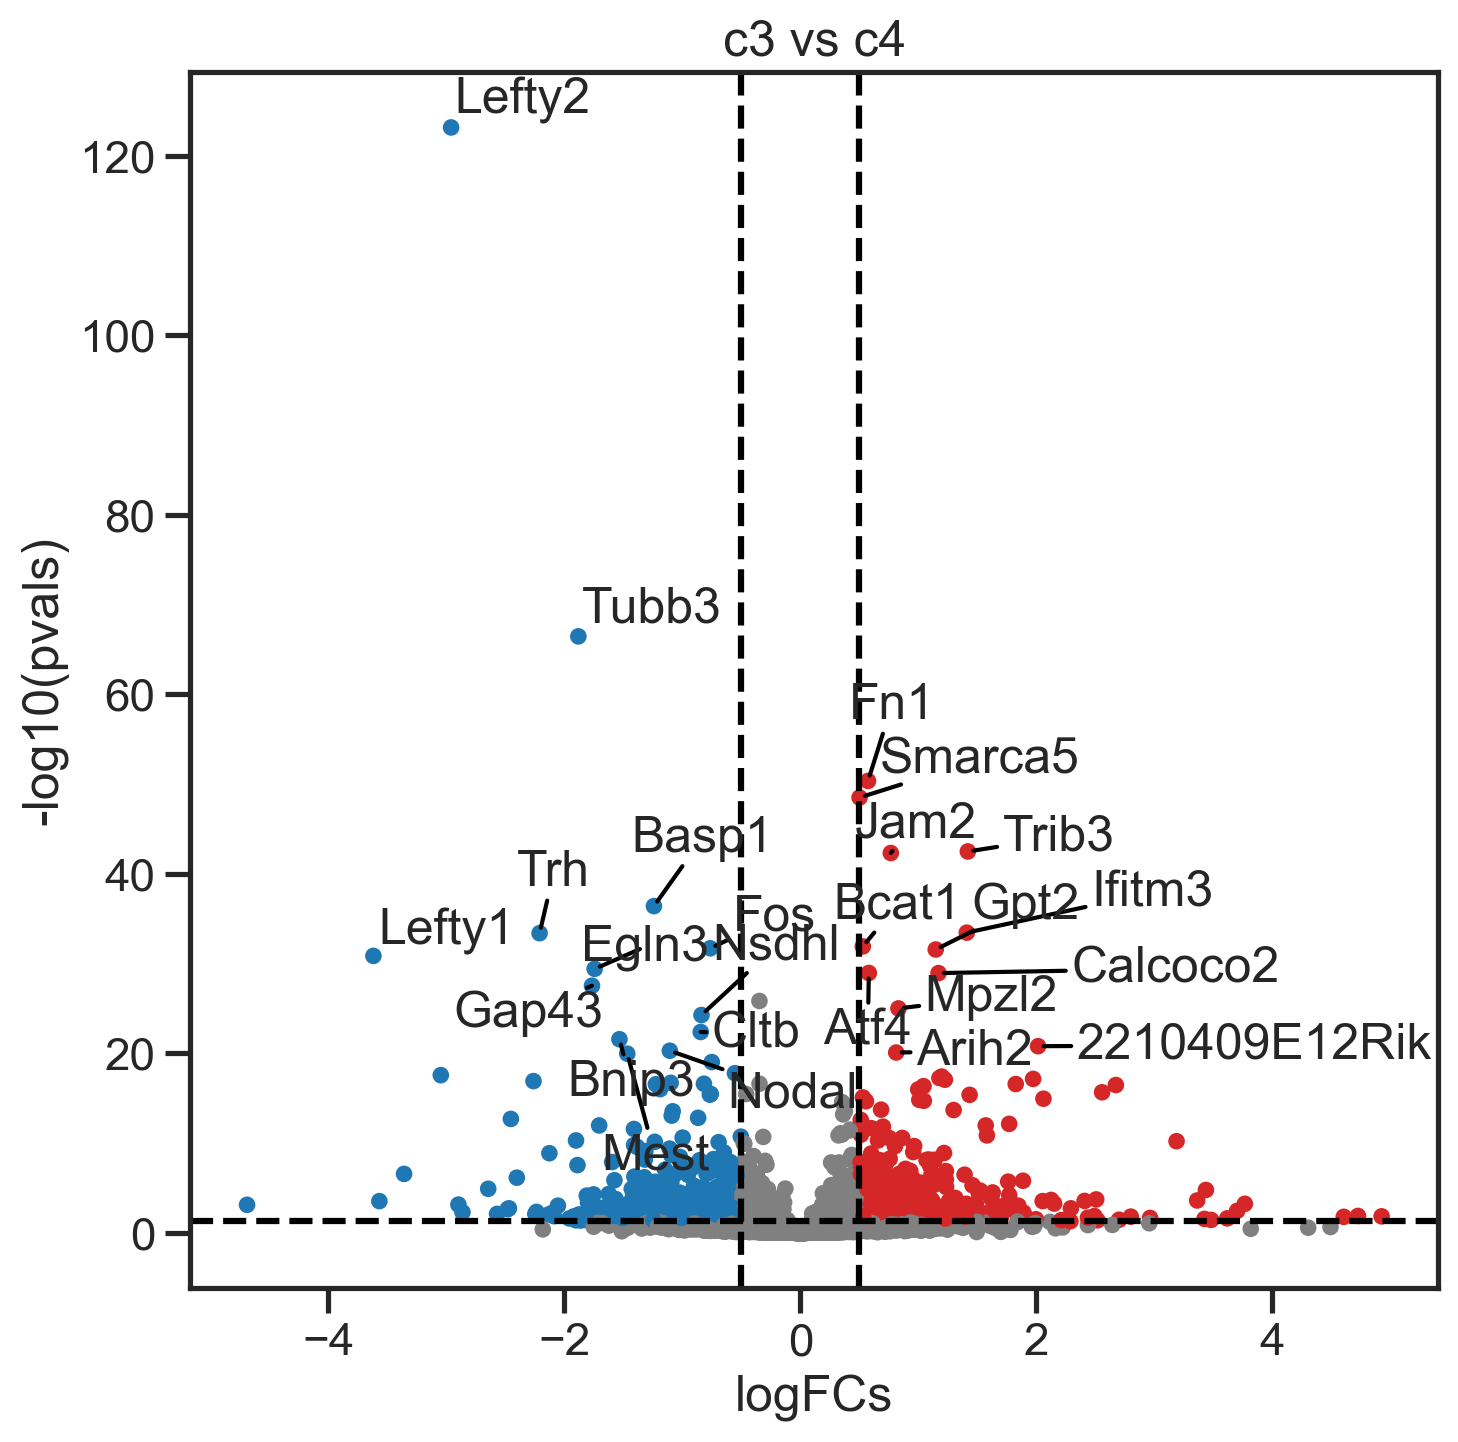

In [75]:
dc.plot_volcano_df(
    results_df_3,
    x='log2FoldChange',
    y='padj',
    top=25,
   # name = 'Jarid2',
    figsize=(8,8),#save='volcano_2ivsESLIF.png'
)
plt.title('c3 vs c4')

In [171]:
def plotGO(df, n_genes = 500,n_GO = 5, save = ''):
    allgenes = list(df.index)
    GOgenes_up = list(df[(df['padj'] < 0.05) & (df['log2FoldChange'] > 0.5) ].sort_values(by=['log2FoldChange','padj']).index)[0:n_genes]
    GOgenes_down = list(df[(df['padj'] < 0.05) & (df['log2FoldChange'] < -0.5) ].sort_values(by=['log2FoldChange','padj']).index)[0:n_genes]
    print('upregulated genes: ' + str(len(list(df[(df['padj'] < 0.05) & (df['log2FoldChange'] > 0.5) ].sort_values(by=['log2FoldChange','padj']).index))))
    print('downregulated genes: ' + str(len(list(df[(df['padj'] < 0.05) & (df['log2FoldChange'] < -0.5) ].sort_values(by=['log2FoldChange','padj']).index))))
    GO_up = sc.queries.enrich({'up':GOgenes_up,
                       'all':allgenes}, org="mmusculus")
    
    GO_down = sc.queries.enrich({'down':GOgenes_down,
                       'all':allgenes}, org="mmusculus")

    plot_up = GO_up[GO_up['query'] == 'up'][GO_up[GO_up['query'] == 'up']['source'] == 'GO:BP'].sort_values(by='p_value')[['name','p_value']][0:n_GO]
    plot_up['-log (p-value)'] = np.log10(plot_up['p_value'])*-1
    sns.set_style('ticks')
    sns.set_context('talk')
    fig, ax = plt.subplots(figsize = (5,2))
    ax = sns.barplot(y=plot_up['name'],x=plot_up['-log (p-value)'], color = '#D62728')
    ax.set_ylabel('')
    ax.set_xlim([0,47])
    plt.savefig('figures/' + save + '_up.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

    plot_down = GO_down[GO_down['query'] == 'down'][GO_down[GO_down['query'] == 'down']['source'] == 'GO:BP'].sort_values(by='p_value')[['name','p_value']][0:n_GO]    
    plot_down['-log (p-value)'] = np.log10(plot_down['p_value'])*-1
    sns.set_style('ticks')
    sns.set_context('talk')
    fig, ax = plt.subplots(figsize = (5,2))
    ax = sns.barplot(y=plot_down['name'],x=plot_down['-log (p-value)'], color = '#1F77B4',ax=ax)
    ax.set_ylabel('')
    ax.set_xlim([0,47])
    plt.savefig('figures/' + save + '_down.png', dpi = 300, bbox_inches = 'tight')
    plt.show()
    


upregulated genes: 605
downregulated genes: 499


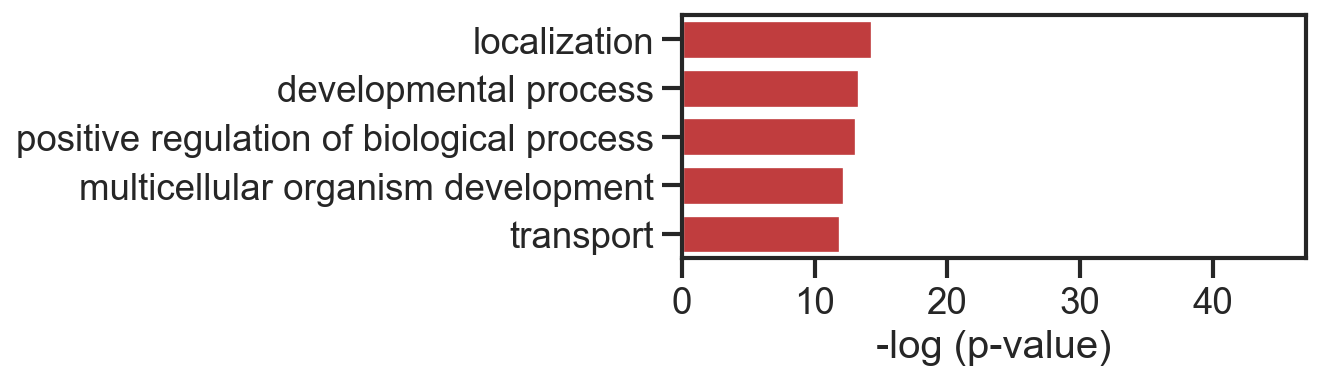

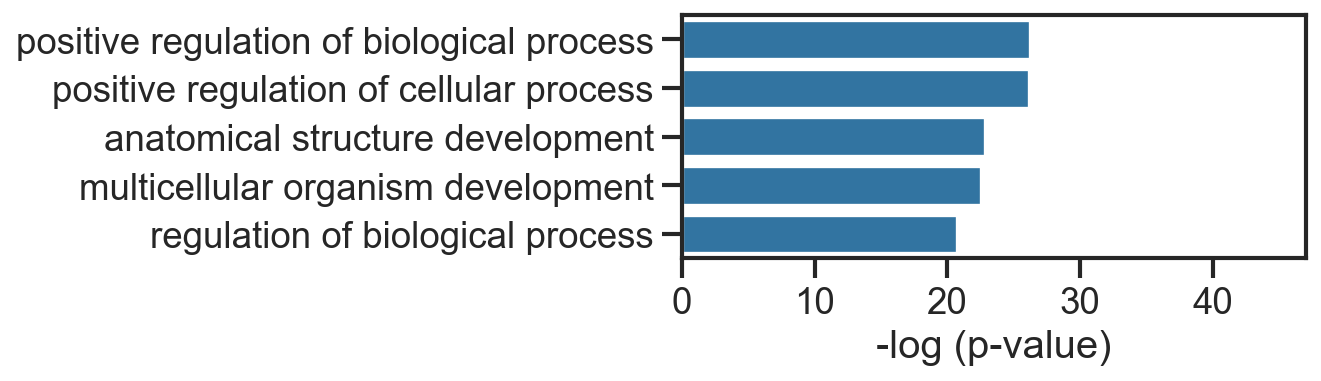

In [172]:
plotGO(results_df_1, n_GO = 5, n_genes = 1000, save = 'c2_vs_c3')

upregulated genes: 1054
downregulated genes: 1092


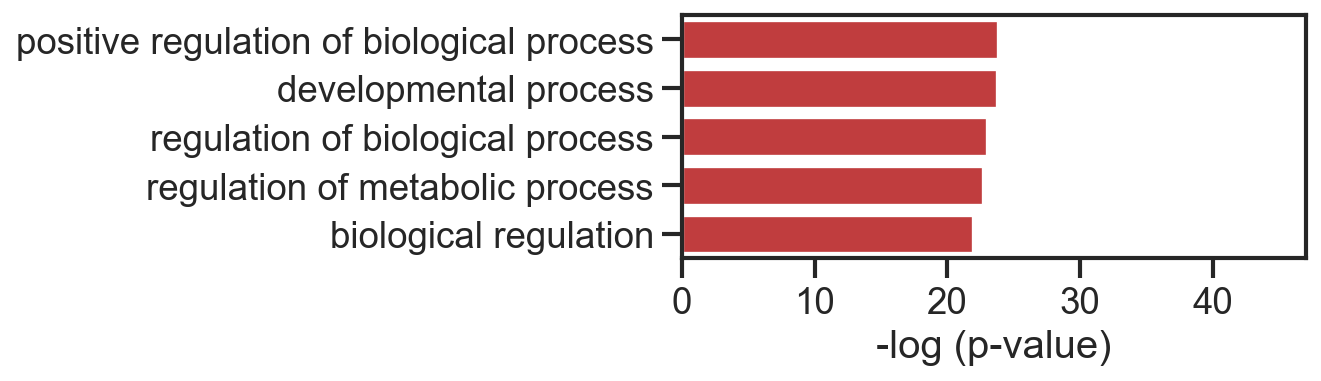

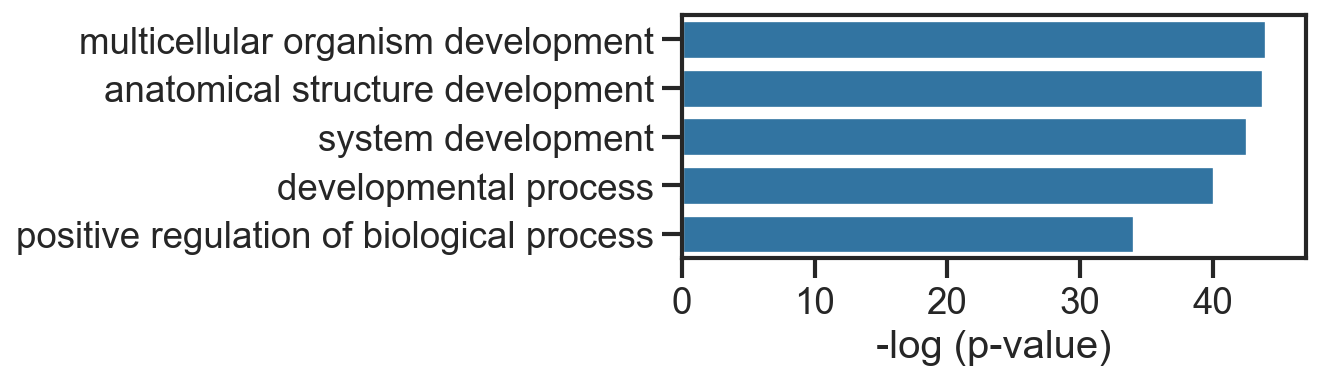

In [173]:
plotGO(results_df_2, n_GO = 5, n_genes = 1000, save = 'c2_vs_c4')

upregulated genes: 418
downregulated genes: 463


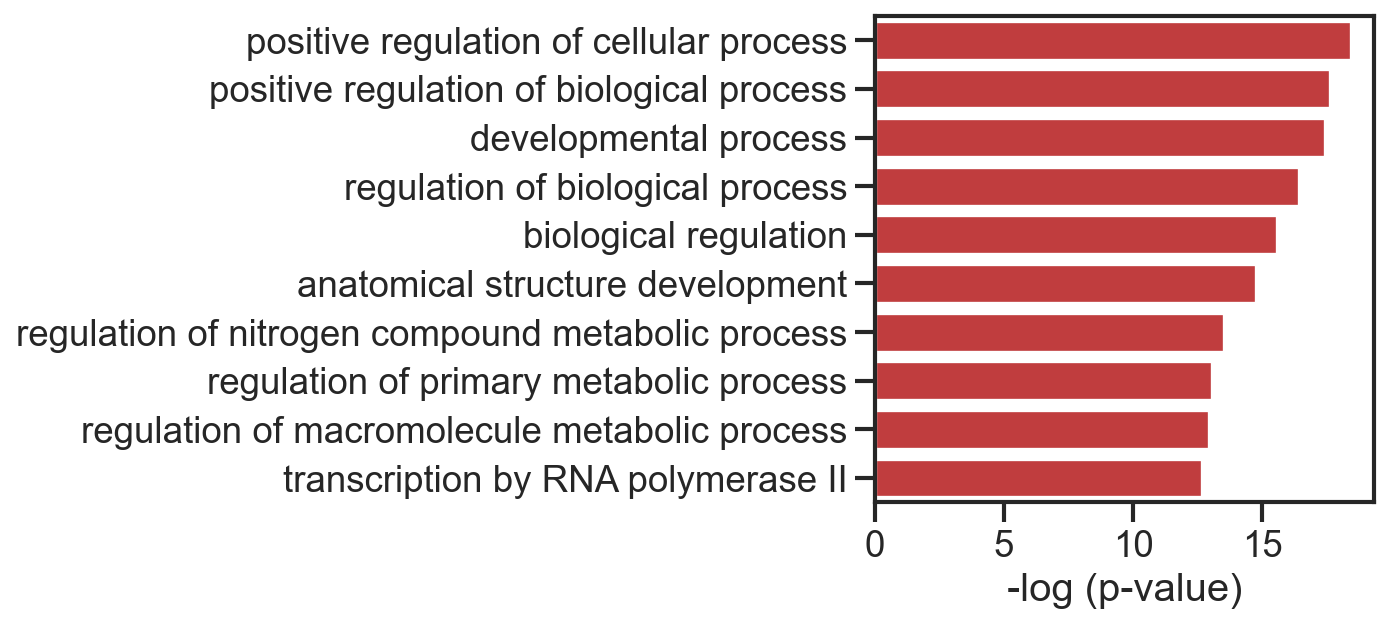

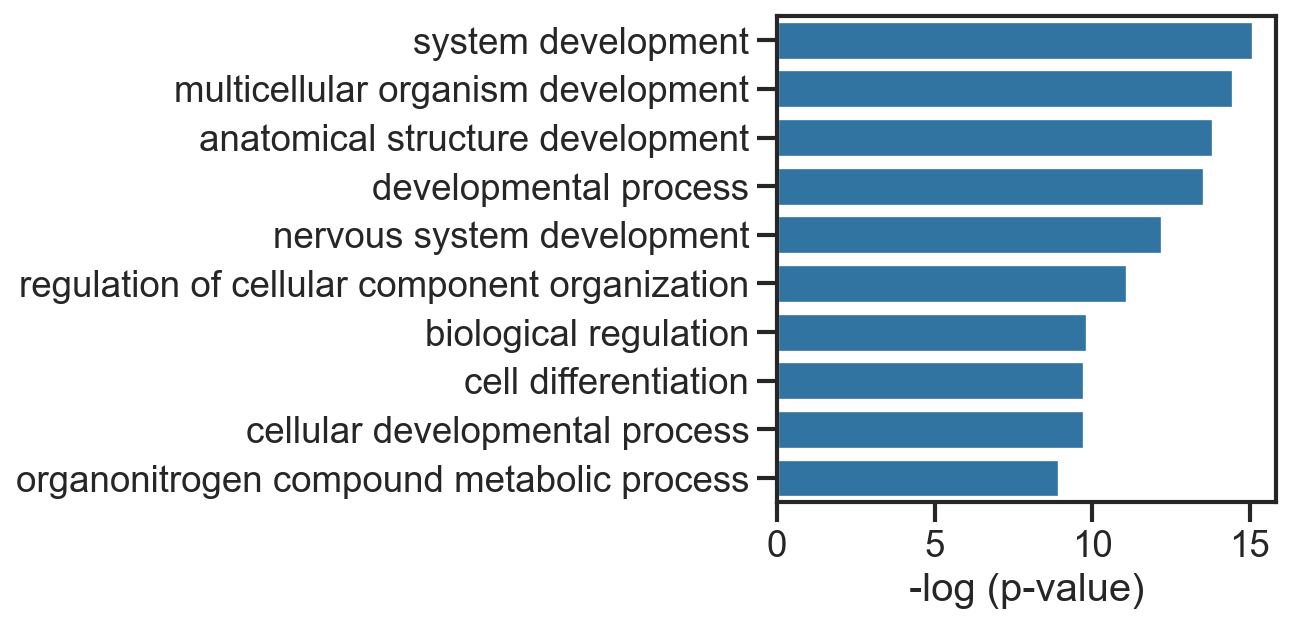

In [101]:
plotGO(results_df_3, n_GO = 10)

PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.\
Here is a brief description of each pathway:

- Androgen: involved in the growth and development of the male reproductive organs.
- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells
- Estrogen: promotes the growth and development of the female reproductive organs.
- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.
- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.
- MAPK: integrates external signals and promotes cell growth and proliferation.
- NFkB: regulates immune response, cytokine production and cell survival.
- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.
- PI3K: promotes growth and proliferation.
- TGFb: involved in development, homeostasis, and repair of most tissues.
- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.
- Trail: induces apoptosis.
- VEGF: mediates angiogenesis, vascular permeability, and cell migration.
- WNT: regulates organ morphogenesis during development and tissue repair.

In [206]:
#progeny = dc.get_progeny(organism='human', top=500)
progeny = pd.read_csv('/Users/m.blotenburg/Documents/Projects/TCHIC/data/jupyter_notebooks/2024/fig4/20240306_progenytable.csv',index_col=0)

progeny


source     weight       p_value   target
0     Androgen  11.490631  0.000000e+00  Tmprss2
1     Androgen  10.622551  2.200000e-44   Nkx3-1
2     Androgen  10.472733  4.600000e-44   Mboat2
5     Androgen   7.363805  1.253072e-39  Slc38a4
6     Androgen   6.130646  2.534403e-38    Mtmr9
...        ...        ...           ...      ...
6995       p53  -2.325751  1.522388e-06    Zmym4
6996       p53  -1.628168  1.526045e-06    Cfdp1
6997       p53   2.309503  1.537098e-06   Vps37d
6998       p53  -2.274823  1.547037e-06    Tedc1
6999       p53  -3.205113  1.568159e-06  Ccdc138

[6530 rows x 4 columns]

In [210]:
adata

AnnData object with n_obs × n_vars = 4147 × 24136
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'batch', 'name', 'condition', 'plate', 'leiden', 'Condition', 'diffx', 'diffx2'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Condition_colors', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [211]:
progeny = progeny[~progeny.duplicated(['source', 'target'])]#.sum()

In [212]:
progeny

source     weight       p_value   target
0     Androgen  11.490631  0.000000e+00  Tmprss2
1     Androgen  10.622551  2.200000e-44   Nkx3-1
2     Androgen  10.472733  4.600000e-44   Mboat2
5     Androgen   7.363805  1.253072e-39  Slc38a4
6     Androgen   6.130646  2.534403e-38    Mtmr9
...        ...        ...           ...      ...
6995       p53  -2.325751  1.522388e-06    Zmym4
6996       p53  -1.628168  1.526045e-06    Cfdp1
6997       p53   2.309503  1.537098e-06   Vps37d
6998       p53  -2.274823  1.547037e-06    Tedc1
6999       p53  -3.205113  1.568159e-06  Ccdc138

[6530 rows x 4 columns]

In [213]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

Running mlm on mat with 4147 samples and 24136 targets for 14 sources.


In [214]:
adata.obsm['mlm_estimate']

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT      MAPK  \
e1_1.m-ESC_con1    2.104353 -2.217131  0.202157 -0.562182 -1.735889  8.499321   
e1_10.m-ESC_con1   1.132115  1.770174  0.643743  3.389817 -0.626709  6.327189   
e1_101.m-ESC_con1  0.454732 -1.740661  0.776611  5.121143 -0.811721  6.133251   
e1_102.m-ESC_con1  1.971719 -1.224481  1.335617  0.510828 -0.582509  7.243279   
e1_103.m-ESC_con1 -0.278676 -0.589855  1.821988  3.855687 -1.291149  7.311734   
...                     ...       ...       ...       ...       ...       ...   
e12_95.m-ESC_con6  1.747039 -0.432323  0.951144  1.370378 -0.866959  6.812813   
e12_96.m-ESC_con6  2.541840 -1.204435 -0.034533  1.034266 -0.770375  6.025337   
e12_97.m-ESC_con6  1.255640 -1.268193 -0.169602 -1.206940  0.746230  6.677048   
e12_98.m-ESC_con6  0.959332 -1.934343  1.174612 -1.880471 -1.208153  4.687961   
e12_99.m-ESC_con6  1.710442 -0.397347  0.915254 -0.883343 -0.034430  6.241391   

                       NFkB      PI3K      TGFb      TNFa      Trail  \
e1_1.m-ESC_con1   -0.955678 -0.325245  1.312794  0.418520 -10.264644   
e1_10.m-ESC_con1  -1.755053 -0.177624  0.569362  1.169396  -8.743318   
e1_101.m-ESC_con1 -1.355809  1.130461  1.744077  0.900342  -9.405442   
e1_102.m-ESC_con1 -1.243189  1.684516  1.333387  0.485776 -10.403489   
e1_103.m-ESC_con1 -0.792500  1.821434  0.848086  0.604755  -9.657322   
...                     ...       ...       ...       ...        ...   
e12_95.m-ESC_con6 -0.879519  1.951762  1.322083  0.646178 -10.912280   
e12_96.m-ESC_con6 -1.498273 -0.155169  0.266159  1.127395 -10.179045   
e12_97.m-ESC_con6 -1.725848  0.708632  1.548266  0.318182  -7.266834   
e12_98.m-ESC_con6 -1.222370  1.606793  0.934724  0.557784 -10.876354   
e12_99.m-ESC_con6 -1.795528  1.048435  1.681465  0.877456 -10.830633   

                       VEGF       WNT       p53  
e1_1.m-ESC_con1    3.206292 -0.585514 -8.838141  
e1_10.m-ESC_con1   1.611966  0.269874 -3.366170  
e1_101.m-ESC_con1  1.332103 -0.578938 -9.524446  
e1_102.m-ESC_con1  1.155116 -1.083733 -7.174922  
e1_103.m-ESC_con1  0.015151 -1.254040 -5.650029  
...                     ...       ...       ...  
e12_95.m-ESC_con6  2.435355 -0.761055 -6.833231  
e12_96.m-ESC_con6  4.185169 -0.168836 -5.863503  
e12_97.m-ESC_con6  2.587549  0.121069 -3.219582  
e12_98.m-ESC_con6  2.096111 -0.508910 -4.746164  
e12_99.m-ESC_con6  2.959165 -0.865380 -5.798455  

[4147 rows x 14 columns]

In [215]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 4147 × 24136
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'batch', 'name', 'condition', 'plate', 'leiden', 'Condition', 'diffx', 'diffx2'
    var: 'ensembl', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'ensembl_chrom'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Condition_colors', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca', 'X_umap', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [216]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 4147 × 14
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase', 'batch', 'name', 'condition', 'plate', 'leiden', 'Condition', 'diffx', 'diffx2'
    uns: 'batch_colors', 'condition_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'Condition_colors', 'diffx_colors', 'diffx2_colors'
    obsm: 'X_pca', 'X_umap', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

/Users/m.blotenburg/miniconda3/envs/multiconda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


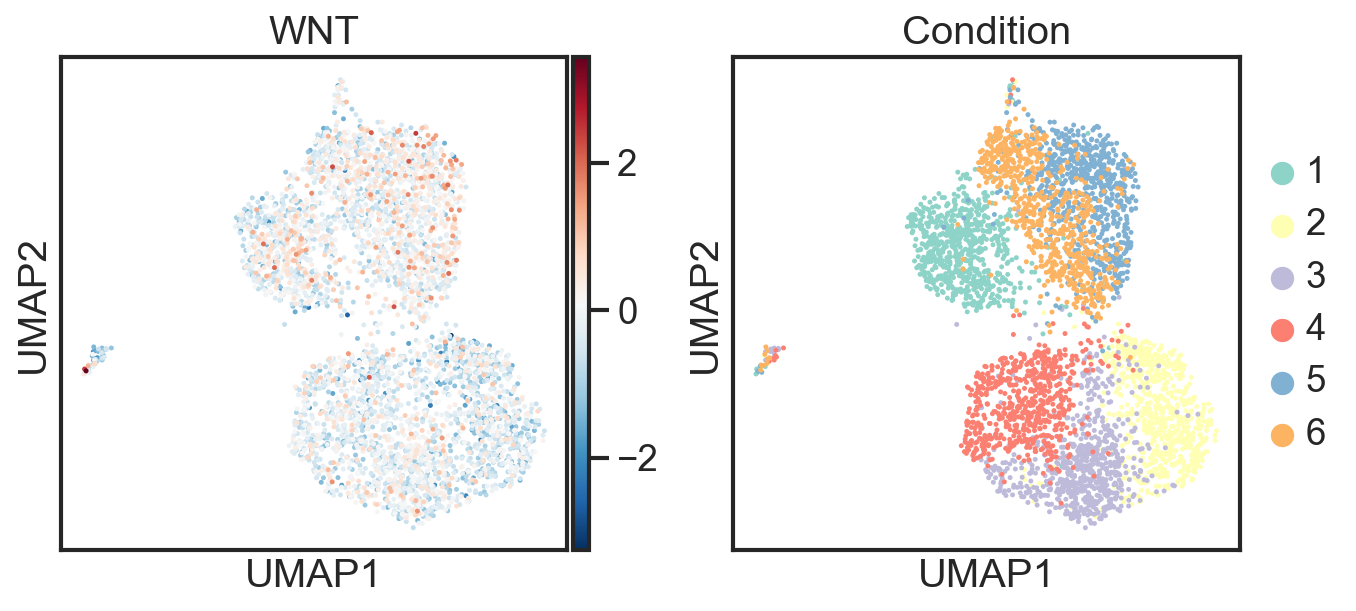

In [218]:
sc.pl.umap(acts, color=['WNT', 'Condition'], cmap='RdBu_r', size = 20)

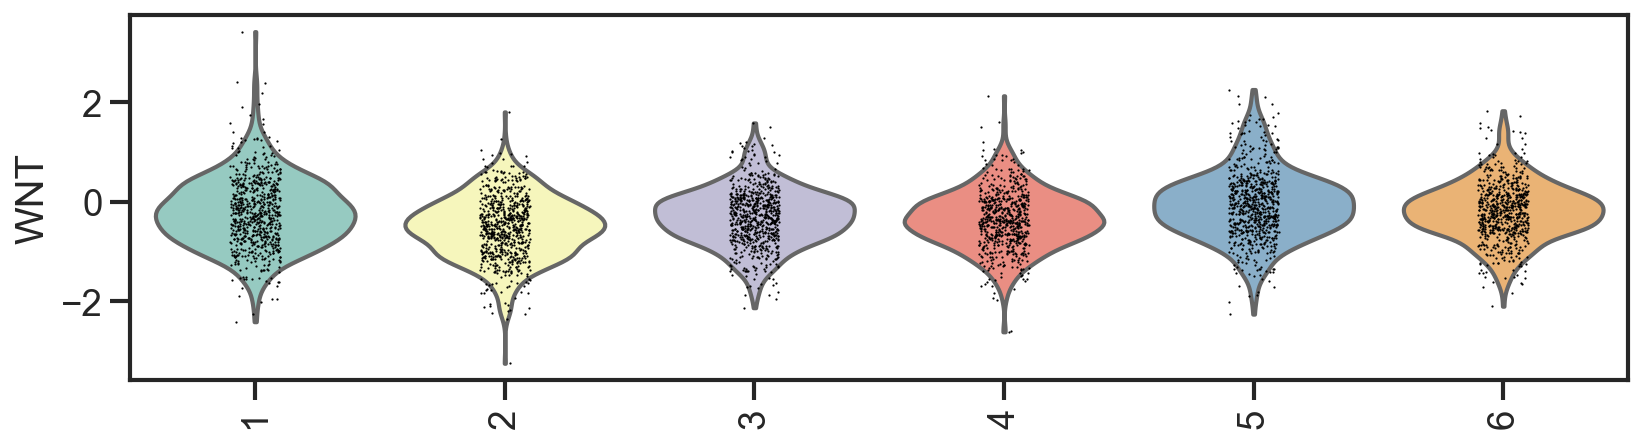

In [221]:
fig,ax=plt.subplots(figsize=(12,3))
sc.pl.violin(acts, keys=['WNT'], groupby='Condition', rotation=90,ax=ax, #cols = adata.uns['Condition_colors'], 
             order = adata.obs['Condition'].cat.categories)

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Condition']`


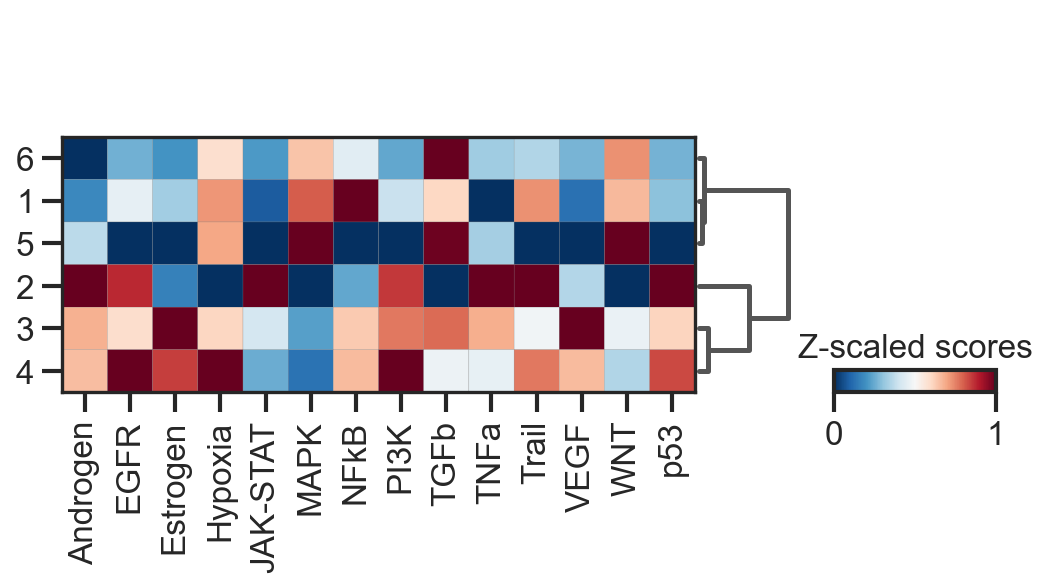

In [222]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='Condition', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

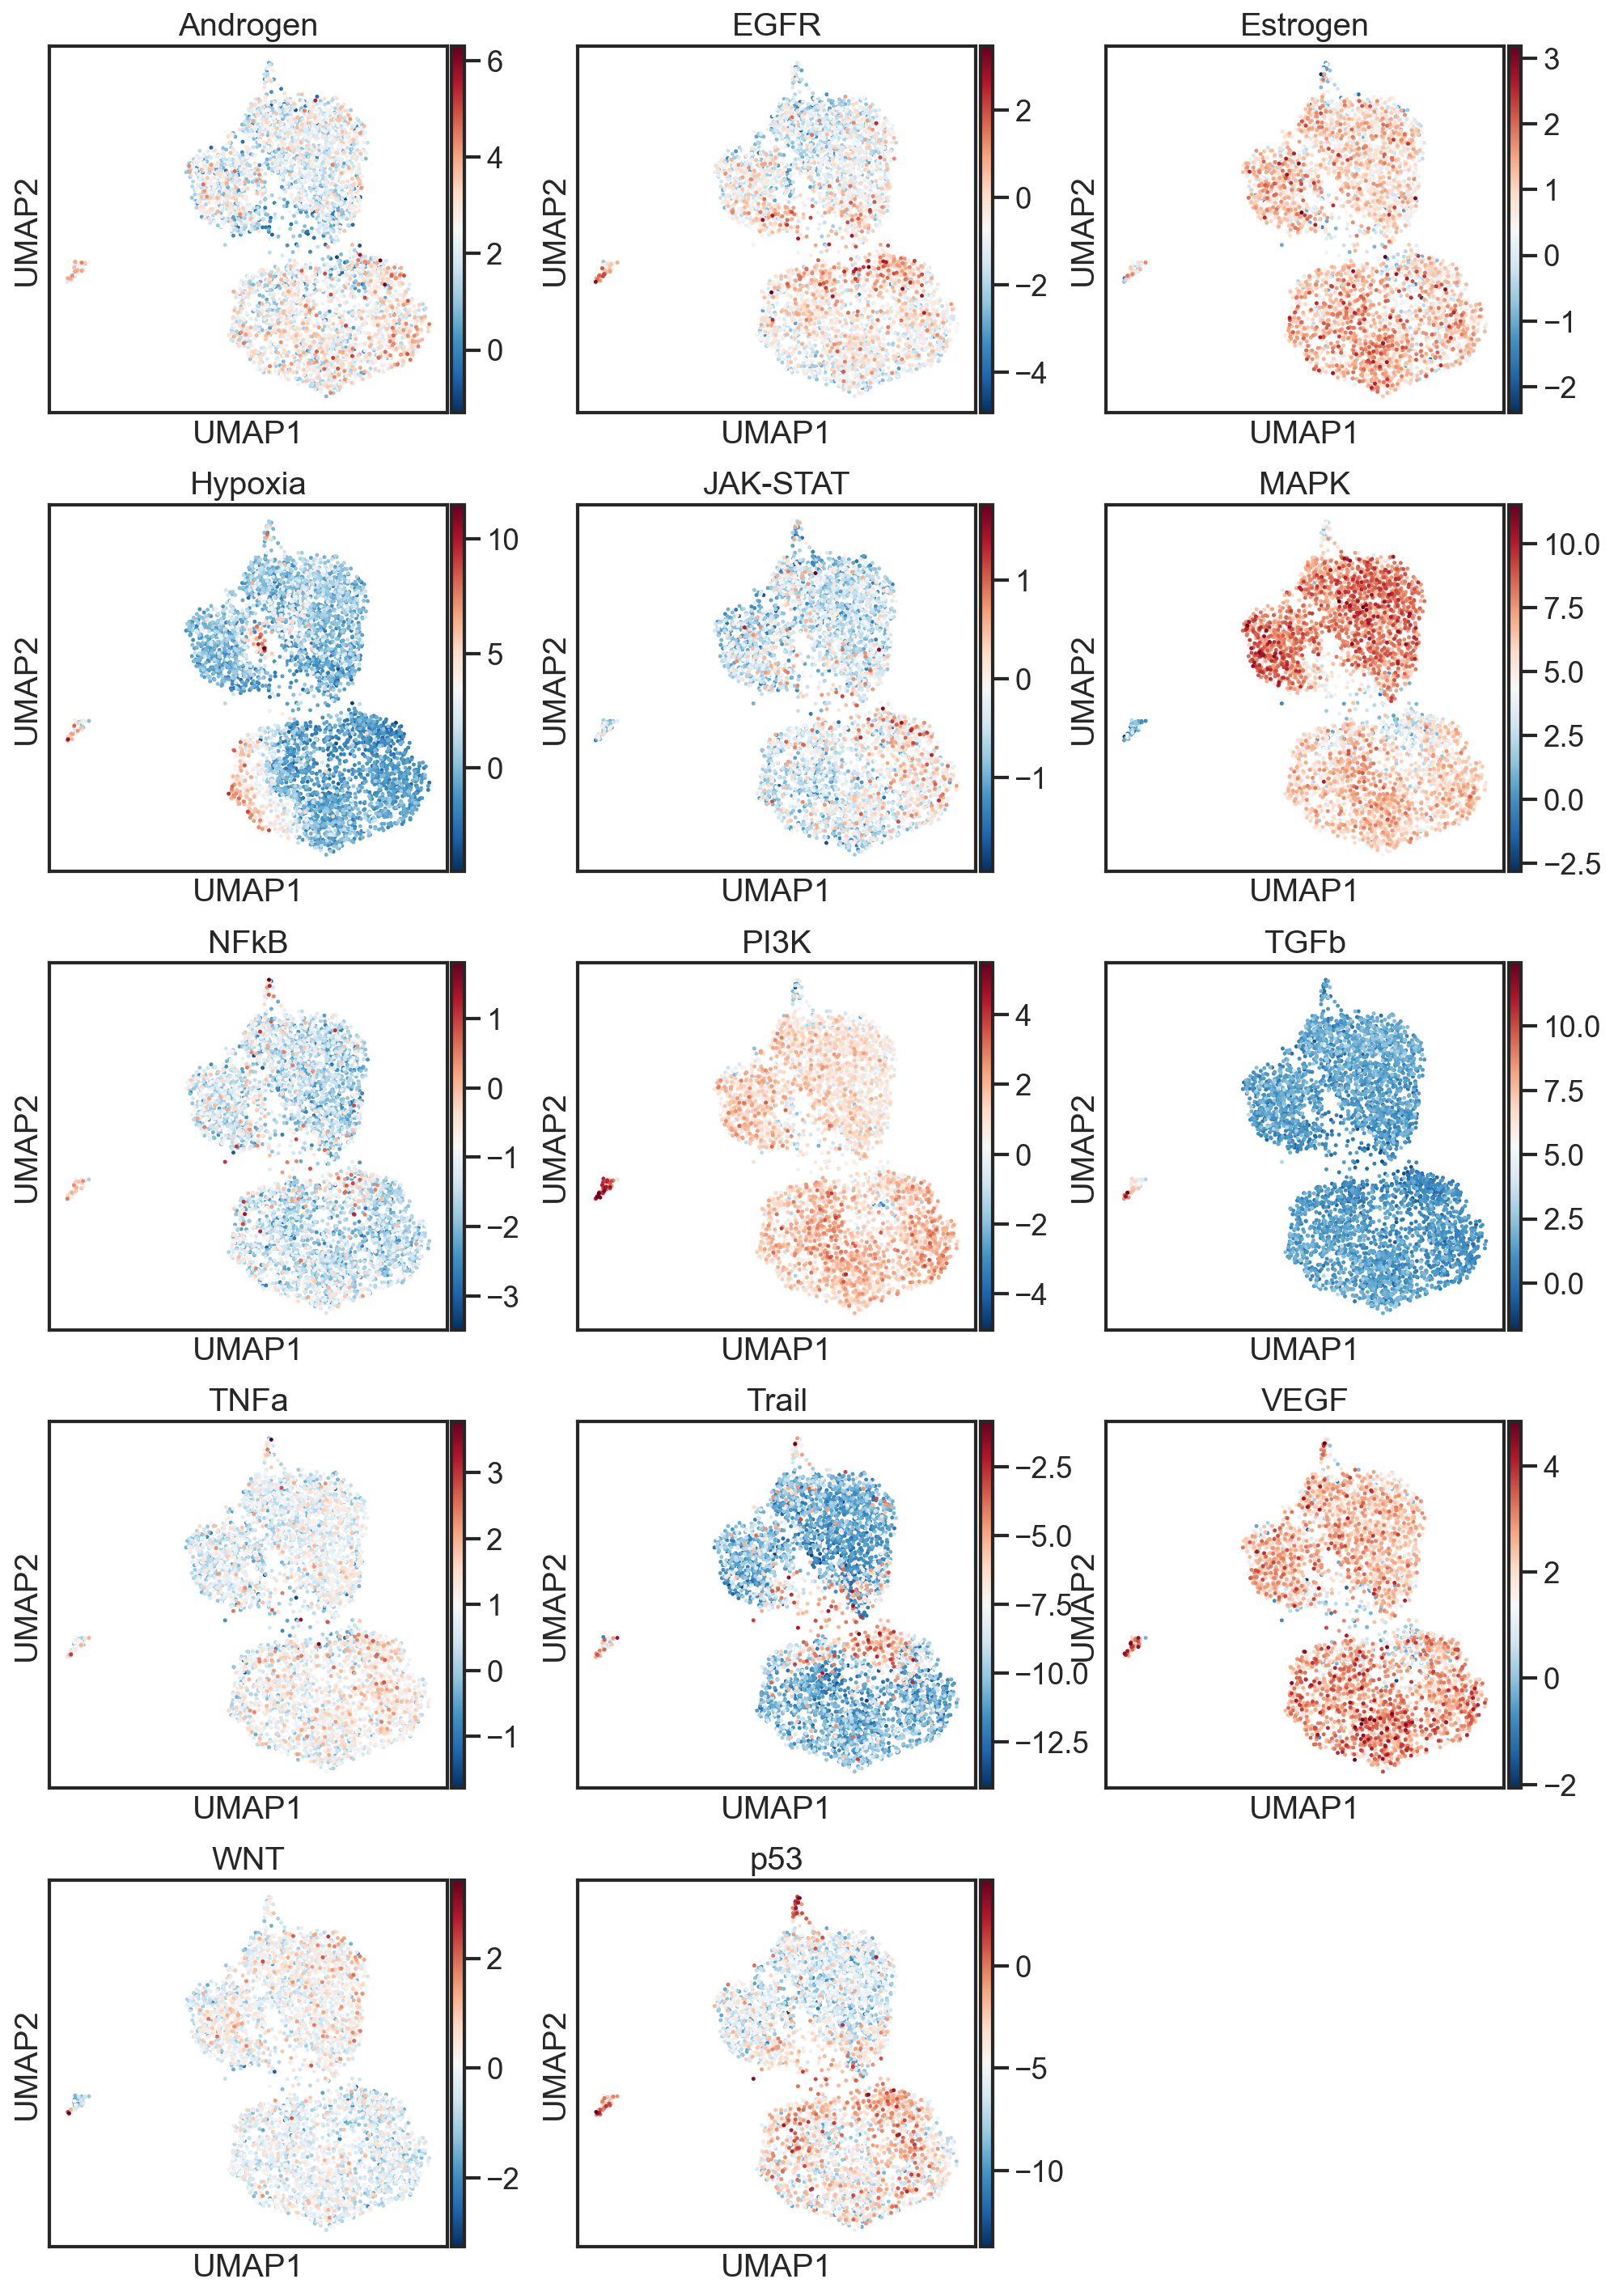

In [223]:
sc.pl.umap(acts, color=acts.var.index, cmap='RdBu_r', size = 20, ncols = 3)